In [37]:
from __future__ import print_function
from matplotlib import pyplot as plt
# get_ipython().magic(u'matplotlib auto')
import tensorflow as tf
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# import torch
from tensorflow import keras
import statistics

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Activation
from tensorflow import reshape
from keras.utils import np_utils
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling1D,AveragePooling1D
from tensorflow.keras.layers import SeparableConv1D, Bidirectional
from tensorflow.keras.layers import LocallyConnected2D
from tensorflow.keras.layers import ZeroPadding2D,ZeroPadding1D, MaxPooling2D, Bidirectional
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import CSVLogger,LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [39]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean
from numpy import std
# import coremltools
# from torch import nn, optim
# import torch.nn.functional as F
import scipy.io
from scipy import stats
#from IPython.display import display, HTML
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import TimeDistributed
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

In [40]:
# The number of steps within one time segment
TIME_PERIODS = 10000
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 10000
N_FEATURES = 12

In [41]:
column_names = ['C'+str(j) for j in range(1, N_FEATURES+1)]
lst = ['Class_label']
column_names = column_names+lst
print(column_names)

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'Class_label']


In [42]:
def read_data_Train(file_path_Train):
    df_Train = pd.read_csv(file_path_Train,header=None,names=column_names)
    # Last column has a ";" character which must be removed ...
    df_Train['Class_label'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    # ... and then this column must be transformed to float explicitly
    df_Train['Class_label'] = df_Train['Class_label'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df_Train.dropna(axis=0, how='any', inplace=True)
    return df_Train
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [43]:
def show_basic_dataframe_info(dataframe):
    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

In [44]:
def read_data_Test(file_path_Test):
    df_Test = pd.read_csv(file_path_Test,header=None,names=column_names)
    # Last column has a ";" character which must be removed ...
    df_Test['Class_label'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    # ... and then this column must be transformed to float explicitly
    df_Test['Class_label'] = df_Test['Class_label'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df_Test.dropna(axis=0, how='any', inplace=True)
    return df_Test

In [45]:
 pd.options.display.float_format = "{:,.5f}".format

In [46]:
# 15 function to segment data into trial lengths (trial length =513 samples in this dataset)
def create_segments_and_labels(df, time_steps,step,n_features, label_name):
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
      for j in range(1, n_features+1):
        L = ('C'+str(j)) 
        segments.append(df[str(L)].values[i: i + time_steps])
      label = stats.mode(df[label_name][i: i + time_steps])[0][0]
      labels.append(label)
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, n_features)
    labels = np.asarray(labels)
    return reshaped_segments, labels

In [47]:
verbose, epochs, batch_size = 0, 120, 16

In [48]:
# def step_decay(epoch):
#    initial_lrate = 0.1
#    drop = 0.1
#    epochs_drop = 16.0
#    lrate = initial_lrate * tf.math.pow(drop,  
#            tf.math.floor((1+epoch)/epochs_drop))
#    return lrate

In [49]:
def step_decay(epoch):
   initial_lrate = 1e-3
   drop = 0.1
   epochs_drop = 40.0
   lrate = initial_lrate * tf.math.pow(drop,  
           tf.math.floor((1+epoch)/epochs_drop))
   return lrate

In [50]:
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [51]:
# lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
test_acc=[]

In [52]:
# import os
# path='/media/naveen/nav/mat_codes/nina_DB2_codes/prep_nbov_olsson/sub_wise_process_TT/'
path='/media/naveen/nav/mat_codes/nina_DB2_codes/prep_nl/sub_wise_process_TT/'


In [53]:
for i in range(1,41):
    file_path_train=path+'S'+str(i)+'_'+'tr'+'.'+'csv'
    print(file_path_train)
    df_Train=read_data_Train(file_path_train)
    show_basic_dataframe_info(df_Train)
    df_Train.head(5)
    file_path_test=path+'S'+str(i)+'_'+'tt'+'.'+'csv'
    print(file_path_test)
    df_Test=read_data_Test(file_path_test)
    show_basic_dataframe_info(df_Test)
    df_Test.head(5)
    
    scaler = preprocessing.StandardScaler().fit(df_Train.iloc[:,0:N_FEATURES])
    df_Train.iloc[:,0:N_FEATURES]=scaler.transform(df_Train.iloc[:,0:N_FEATURES])
    df_Test.iloc[:,0:N_FEATURES]=scaler.transform(df_Test.iloc[:,0:N_FEATURES])
       
    LABEL = 'ActivityEncoded'
    # Transform the labels from String to Integer via LabelEncoder
    le = preprocessing.LabelEncoder()
    # Add a new column to the existing DataFrame with the encoded values
    df_Train[LABEL] = le.fit_transform(df_Train['Class_label'].values.ravel())
    # df_Valid[LABEL] = le.fit_transform(df_Valid['Class_label'].values.ravel())
    df_Test[LABEL] = le.fit_transform(df_Test['Class_label'].values.ravel())
    x_train, y_train = create_segments_and_labels(df_Train,TIME_PERIODS,STEP_DISTANCE,N_FEATURES,LABEL)
    print('x_train shape: ', x_train.shape)
    # print(x_train)
    print(x_train.shape[0], 'training samples')
    print('y_train shape: ', y_train.shape)
    # Set input & output dimensions
    num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
    print('num_time_periods',num_time_periods)
    print('num_sensors',num_sensors)
    num_classes = le.classes_.size
    print('class_list',list(le.classes_))
    # input_shape = (num_time_periods,num_sensors)
    # print(input_shape)
    input_shape = (num_time_periods,num_sensors)
    #x_train = x_train.reshape(x_train.shape[0], input_shape)
    print('x_train shape:', x_train[0].shape)
    print('input_shape:', input_shape)
    x_train = x_train.astype('float32')
    # x_train = [torch.tensor(arr, dtype=torch.float32) for arr in x_train]
    # y_train = y_train.astype('float32')
    print('y_train shape',y_train.shape)
    y_train_hot = np_utils.to_categorical(y_train, num_classes)
#     print(y_train_hot)
    # y_train_hot= [torch.tensor(arr, dtype=torch.uint8) for arr in y_train_hot]
    print('New y_train shape: ', y_train_hot.shape)
    x_test, y_test = create_segments_and_labels(df_Test,TIME_PERIODS,STEP_DISTANCE,N_FEATURES,LABEL)
    print('x_test shape: ', x_test.shape)
    # print(x_train)
    print(x_test.shape[0], 'testing samples')
    print('y_test shape: ', y_test.shape)
    # Set input_shape / reshape for Keras
    #x_test = x_test.reshape(x_test.shape[0], input_shape)
    x_test = x_test.astype('float32')
    y_test = y_test.astype('float32')
    y_test_hot = np_utils.to_categorical(y_test, num_classes)
    # n_steps, n_length = 20, 25
    # n_steps, n_length= 10, 50
    # n_steps, n_length= 16, 32
    n_steps, n_length = 25, 400
    n_depth=12
    x_train = x_train.reshape(x_train.shape[0], n_steps, n_length,n_depth)
    print('x_train shape: ', x_train.shape)
    # x_valid = x_valid.reshape(x_valid.shape[0], n_steps, n_length, n_depth)
    # print('x_valid shape: ', x_valid.shape)
    x_test = x_test.reshape(x_test.shape[0], n_steps, n_length,n_depth)
    print('x_test shape: ', x_test.shape)
    n_outputs = y_train_hot.shape[1]
    print('n_outputs',n_outputs)
    # chen architecture
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=32, kernel_size=2, padding='same', kernel_initializer="he_normal",strides=1,kernel_regularizer=l1(1e-04)), \
                               input_shape=(n_steps,n_length,n_depth)))
    model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=4,strides=2)))
    model.add(TimeDistributed(Activation('tanh')))
    model.add(TimeDistributed(Conv1D(filters=16, kernel_size=2,padding="same",kernel_initializer="he_normal",strides=1,kernel_regularizer=l1(1e-04))))
    model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=4,strides=2)))
    model.add(TimeDistributed(Activation('tanh')))
    model.add(TimeDistributed(Dropout(0.2093)))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(Flatten()))
    # model.add(Flatten())
    model.add(LSTM(64,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='tanh'))
    model.add(BatchNormalization(epsilon=1e-05, momentum=0.9, weights=None))
    model.add(Dense(n_outputs, activation='softmax'))
#     adam=optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, amsgrad=False)
    adam=optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999,epsilon=1e-08, amsgrad=False)
    checkpoint_filepath = '/media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5'
    # model.load_weights(checkpoint_filepath) 
    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,verbose=1, monitor='val_accuracy',save_weights_only=True,save_best_only=True)
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
    model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
    print(model.summary())
#     tf.keras.utils.plot_model(model, to_file='/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/olsson/CNN20X10/Model1.png',show_shapes=True,show_layer_names=True,dpi=96)
    csv_logger = CSVLogger('/media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/LSTM_nina_20X100.csv', append=True, separator=';')
    history = model.fit(x_train, y_train_hot, epochs=epochs, batch_size=batch_size, callbacks=[csv_logger,checkpoint_callback,lrate],validation_data=(x_test, y_test_hot), verbose=1)
    best_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
    print('epoch_number',best_index+1)
    print('train accuracy and validation accuracy', history.history['accuracy'][best_index], history.history['val_accuracy'][best_index])
    model.load_weights(checkpoint_filepath) 
    _, testaccuracy = model.evaluate(x_test, y_test_hot, batch_size=batch_size, verbose=1)
    print('test_accuracy',testaccuracy)
    test_acc.append(testaccuracy)
    print(test_acc)
    print('test_mean for %d subjects:',i)
#     print(test_acc)
    test_mean=statistics.mean(test_acc)
    print(test_mean)

/media/naveen/nav/mat_codes/nina_DB2_codes/prep_nl/sub_wise_process_TT/S1_tr.csv
Number of columns in the dataframe: 13
Number of rows in the dataframe: 1960000

/media/naveen/nav/mat_codes/nina_DB2_codes/prep_nl/sub_wise_process_TT/S1_tt.csv
Number of columns in the dataframe: 13
Number of rows in the dataframe: 980000

x_train shape:  (195, 10000, 12)
195 training samples
y_train shape:  (195,)
num_time_periods 10000
num_sensors 12
class_list [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0]
x_train shape: (10000, 12)
input_shape: (10000, 12)
y_train shape (195,)
New y_train shape:  (195, 49)
x_test shape:  (97, 10000, 12)
97 testing samples
y_test shape:  (97,)
x_train shape:  (195, 25, 400, 12)
x_test shape:  (97, 25, 400, 12)
n_outputs 49
Model: "se

Epoch 13/120
13/13 [==============================] - ETA: 0s - loss: 0.8324 - accuracy: 0.8256
Epoch 00013: val_accuracy did not improve from 0.77320
13/13 [==============================] - 0s 24ms/step - loss: 0.8324 - accuracy: 0.8256 - val_loss: 1.0415 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 14/120
12/13 [==========================>...] - ETA: 0s - loss: 0.6583 - accuracy: 0.8906
Epoch 00014: val_accuracy did not improve from 0.77320
13/13 [==============================] - 0s 24ms/step - loss: 0.6760 - accuracy: 0.8769 - val_loss: 0.9754 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 15/120
12/13 [==========================>...] - ETA: 0s - loss: 0.6068 - accuracy: 0.9167
Epoch 00015: val_accuracy did not improve from 0.77320
13/13 [==============================] - 0s 23ms/step - loss: 0.6236 - accuracy: 0.9026 - val_loss: 0.9422 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 16/120
12/13 [==========================>...] - ETA: 0s - loss: 0.5590 - accuracy: 0.9167
Epoch 00016: val_accur

Epoch 40/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1760 - accuracy: 0.9688
Epoch 00040: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 23ms/step - loss: 0.1804 - accuracy: 0.9692 - val_loss: 0.5293 - val_accuracy: 0.8763 - lr: 1.0000e-04
Epoch 41/120
13/13 [==============================] - ETA: 0s - loss: 0.1475 - accuracy: 0.9949
Epoch 00041: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 22ms/step - loss: 0.1475 - accuracy: 0.9949 - val_loss: 0.5195 - val_accuracy: 0.8866 - lr: 1.0000e-04
Epoch 42/120
13/13 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.9949
Epoch 00042: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 23ms/step - loss: 0.1122 - accuracy: 0.9949 - val_loss: 0.5500 - val_accuracy: 0.8660 - lr: 1.0000e-04
Epoch 43/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1284 - accuracy: 0.9948
Epoch 0004

Epoch 68/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0735 - accuracy: 0.9948
Epoch 00068: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 24ms/step - loss: 0.0966 - accuracy: 0.9846 - val_loss: 0.5699 - val_accuracy: 0.8454 - lr: 1.0000e-04
Epoch 69/120
10/13 [======================>.......] - ETA: 0s - loss: 0.0786 - accuracy: 1.0000
Epoch 00069: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 26ms/step - loss: 0.0836 - accuracy: 1.0000 - val_loss: 0.5823 - val_accuracy: 0.8763 - lr: 1.0000e-04
Epoch 70/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0888 - accuracy: 0.9943
Epoch 00070: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 28ms/step - loss: 0.0913 - accuracy: 0.9949 - val_loss: 0.5924 - val_accuracy: 0.8763 - lr: 1.0000e-04
Epoch 71/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0847 - accuracy: 1.0000
Epoch 0007

Epoch 96/120
13/13 [==============================] - ETA: 0s - loss: 0.0953 - accuracy: 0.9897
Epoch 00096: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 27ms/step - loss: 0.0953 - accuracy: 0.9897 - val_loss: 0.5591 - val_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 97/120
13/13 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 1.0000
Epoch 00097: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 25ms/step - loss: 0.0771 - accuracy: 1.0000 - val_loss: 0.5506 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 98/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0667 - accuracy: 1.0000
Epoch 00098: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 27ms/step - loss: 0.0678 - accuracy: 1.0000 - val_loss: 0.5381 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 99/120
10/13 [======================>.......] - ETA: 0s - loss: 0.0758 - accuracy: 1.0000
Epoch 0009

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_462 (TimeDi (None, 25, 400, 32)       800       
_________________________________________________________________
time_distributed_463 (TimeDi (None, 25, 400, 32)       128       
_________________________________________________________________
time_distributed_464 (TimeDi (None, 25, 199, 32)       0         
_________________________________________________________________
time_distributed_465 (TimeDi (None, 25, 199, 32)       0         
_________________________________________________________________
time_distributed_466 (TimeDi (None, 25, 199, 16)       1040      
_________________________________________________________________
time_distributed_467 (TimeDi (None, 25, 199, 16)       64        
_________________________________________________________________
time_distributed_468 (TimeDi (None, 25, 98, 16)      

Epoch 16/120
12/13 [==========================>...] - ETA: 0s - loss: 0.5414 - accuracy: 0.9479
Epoch 00016: val_accuracy did not improve from 0.81443
13/13 [==============================] - 0s 21ms/step - loss: 0.5476 - accuracy: 0.9487 - val_loss: 0.9485 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 17/120
12/13 [==========================>...] - ETA: 0s - loss: 0.4909 - accuracy: 0.9219
Epoch 00017: val_accuracy did not improve from 0.81443
13/13 [==============================] - 0s 22ms/step - loss: 0.5027 - accuracy: 0.9179 - val_loss: 0.9112 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 18/120
12/13 [==========================>...] - ETA: 0s - loss: 0.4134 - accuracy: 0.9375
Epoch 00018: val_accuracy did not improve from 0.81443
13/13 [==============================] - 0s 23ms/step - loss: 0.4245 - accuracy: 0.9282 - val_loss: 0.8802 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 19/120
11/13 [========================>.....] - ETA: 0s - loss: 0.4749 - accuracy: 0.9489
Epoch 00019: val_accur

13/13 [==============================] - 0s 25ms/step - loss: 0.0953 - accuracy: 1.0000 - val_loss: 0.6914 - val_accuracy: 0.8660 - lr: 1.0000e-04
Epoch 43/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1107 - accuracy: 0.9948
Epoch 00043: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 23ms/step - loss: 0.1179 - accuracy: 0.9949 - val_loss: 0.6916 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 44/120
13/13 [==============================] - ETA: 0s - loss: 0.1060 - accuracy: 1.0000
Epoch 00044: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 22ms/step - loss: 0.1060 - accuracy: 1.0000 - val_loss: 0.6828 - val_accuracy: 0.8660 - lr: 1.0000e-04
Epoch 45/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0905 - accuracy: 1.0000
Epoch 00045: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 24ms/step - loss: 0.0940 - accuracy: 1.0000 - val_loss: 0.6958

Epoch 70/120
13/13 [==============================] - ETA: 0s - loss: 0.0849 - accuracy: 1.0000
Epoch 00070: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 22ms/step - loss: 0.0849 - accuracy: 1.0000 - val_loss: 0.6583 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 71/120
13/13 [==============================] - ETA: 0s - loss: 0.0982 - accuracy: 1.0000
Epoch 00071: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 22ms/step - loss: 0.0982 - accuracy: 1.0000 - val_loss: 0.6523 - val_accuracy: 0.8660 - lr: 1.0000e-04
Epoch 72/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0911 - accuracy: 1.0000
Epoch 00072: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 22ms/step - loss: 0.0984 - accuracy: 1.0000 - val_loss: 0.6550 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 73/120
13/13 [==============================] - ETA: 0s - loss: 0.0992 - accuracy: 0.9897
Epoch 0007

Epoch 98/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0808 - accuracy: 1.0000
Epoch 00098: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 24ms/step - loss: 0.0801 - accuracy: 1.0000 - val_loss: 0.6661 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 99/120
13/13 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 1.0000
Epoch 00099: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 21ms/step - loss: 0.0820 - accuracy: 1.0000 - val_loss: 0.6570 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 100/120
13/13 [==============================] - ETA: 0s - loss: 0.0850 - accuracy: 1.0000
Epoch 00100: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 21ms/step - loss: 0.0850 - accuracy: 1.0000 - val_loss: 0.6503 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 101/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0725 - accuracy: 1.0000
Epoch 00

13/13 [==============================] - ETA: 0s - loss: 4.6038 - accuracy: 0.0205
Epoch 00001: val_accuracy improved from -inf to 0.05155, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 68ms/step - loss: 4.6038 - accuracy: 0.0205 - val_loss: 3.9024 - val_accuracy: 0.0515 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 3.7335 - accuracy: 0.0974
Epoch 00002: val_accuracy improved from 0.05155 to 0.22680, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 24ms/step - loss: 3.7335 - accuracy: 0.0974 - val_loss: 3.0506 - val_accuracy: 0.2268 - lr: 0.0010
Epoch 3/120
12/13 [==========================>...] - ETA: 0s - loss: 2.9706 - accuracy: 0.1979
Epoch 00003: val_accuracy improved from 0.22680 to 0.38144, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CN

12/13 [==========================>...] - ETA: 0s - loss: 0.1980 - accuracy: 0.9896
Epoch 00025: val_accuracy did not improve from 0.93814
13/13 [==============================] - 0s 24ms/step - loss: 0.2141 - accuracy: 0.9846 - val_loss: 0.3130 - val_accuracy: 0.9381 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.1931 - accuracy: 0.9897
Epoch 00026: val_accuracy did not improve from 0.93814
13/13 [==============================] - 0s 23ms/step - loss: 0.1931 - accuracy: 0.9897 - val_loss: 0.3210 - val_accuracy: 0.9072 - lr: 0.0010
Epoch 27/120
13/13 [==============================] - ETA: 0s - loss: 0.1714 - accuracy: 0.9949
Epoch 00027: val_accuracy did not improve from 0.93814
13/13 [==============================] - 0s 24ms/step - loss: 0.1714 - accuracy: 0.9949 - val_loss: 0.3316 - val_accuracy: 0.9278 - lr: 0.0010
Epoch 28/120
13/13 [==============================] - ETA: 0s - loss: 0.1554 - accuracy: 0.9846
Epoch 00028: val_accuracy improved 

Epoch 52/120
13/13 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.96907
13/13 [==============================] - 0s 23ms/step - loss: 0.0960 - accuracy: 1.0000 - val_loss: 0.2275 - val_accuracy: 0.9691 - lr: 1.0000e-04
Epoch 53/120
13/13 [==============================] - ETA: 0s - loss: 0.1187 - accuracy: 0.9897
Epoch 00053: val_accuracy did not improve from 0.96907
13/13 [==============================] - 0s 22ms/step - loss: 0.1187 - accuracy: 0.9897 - val_loss: 0.2262 - val_accuracy: 0.9485 - lr: 1.0000e-04
Epoch 54/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0976 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.96907
13/13 [==============================] - 0s 22ms/step - loss: 0.0972 - accuracy: 1.0000 - val_loss: 0.2177 - val_accuracy: 0.9691 - lr: 1.0000e-04
Epoch 55/120
13/13 [==============================] - ETA: 0s - loss: 0.1098 - accuracy: 0.9949
Epoch 0005

Epoch 80/120
13/13 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.96907
13/13 [==============================] - 0s 23ms/step - loss: 0.0722 - accuracy: 1.0000 - val_loss: 0.2121 - val_accuracy: 0.9588 - lr: 1.0000e-05
Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.0831 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.96907
13/13 [==============================] - 0s 24ms/step - loss: 0.0831 - accuracy: 1.0000 - val_loss: 0.2085 - val_accuracy: 0.9485 - lr: 1.0000e-05
Epoch 82/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0865 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.96907
13/13 [==============================] - 0s 25ms/step - loss: 0.0889 - accuracy: 1.0000 - val_loss: 0.2077 - val_accuracy: 0.9485 - lr: 1.0000e-05
Epoch 83/120
13/13 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9949
Epoch 0008

Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 1.0000
Epoch 00108: val_accuracy improved from 0.96907 to 0.97938, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 26ms/step - loss: 0.0822 - accuracy: 1.0000 - val_loss: 0.1925 - val_accuracy: 0.9794 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.1114 - accuracy: 0.9949
Epoch 00109: val_accuracy did not improve from 0.97938
13/13 [==============================] - 0s 23ms/step - loss: 0.1114 - accuracy: 0.9949 - val_loss: 0.1997 - val_accuracy: 0.9588 - lr: 1.0000e-05
Epoch 110/120
13/13 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.97938
13/13 [==============================] - 0s 23ms/step - loss: 0.0816 - accuracy: 1.0000 - val_loss: 0.2045 - val_accuracy: 0.9588 - lr: 1.0000e-05
Ep

12/13 [==========================>...] - ETA: 0s - loss: 4.4420 - accuracy: 0.0365
Epoch 00001: val_accuracy improved from -inf to 0.05155, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 64ms/step - loss: 4.4423 - accuracy: 0.0359 - val_loss: 3.8548 - val_accuracy: 0.0515 - lr: 0.0010
Epoch 2/120
12/13 [==========================>...] - ETA: 0s - loss: 3.7971 - accuracy: 0.0885
Epoch 00002: val_accuracy improved from 0.05155 to 0.11340, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 24ms/step - loss: 3.8050 - accuracy: 0.0872 - val_loss: 3.6252 - val_accuracy: 0.1134 - lr: 0.0010
Epoch 3/120
13/13 [==============================] - ETA: 0s - loss: 3.2812 - accuracy: 0.1333
Epoch 00003: val_accuracy improved from 0.11340 to 0.31959, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CN

Epoch 25/120
13/13 [==============================] - ETA: 0s - loss: 0.2936 - accuracy: 0.9744
Epoch 00025: val_accuracy did not improve from 0.76289
13/13 [==============================] - 0s 22ms/step - loss: 0.2936 - accuracy: 0.9744 - val_loss: 0.9586 - val_accuracy: 0.7526 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.9795
Epoch 00026: val_accuracy improved from 0.76289 to 0.77320, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 27ms/step - loss: 0.2331 - accuracy: 0.9795 - val_loss: 0.9035 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 27/120
13/13 [==============================] - ETA: 0s - loss: 0.2301 - accuracy: 0.9641
Epoch 00027: val_accuracy did not improve from 0.77320
13/13 [==============================] - 0s 21ms/step - loss: 0.2301 - accuracy: 0.9641 - val_loss: 0.8650 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 28/120
13/1

Epoch 52/120
13/13 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.9897
Epoch 00052: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 27ms/step - loss: 0.1423 - accuracy: 0.9897 - val_loss: 0.6780 - val_accuracy: 0.8351 - lr: 1.0000e-04
Epoch 53/120
10/13 [======================>.......] - ETA: 0s - loss: 0.0985 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 26ms/step - loss: 0.1059 - accuracy: 1.0000 - val_loss: 0.6867 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 54/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0893 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 26ms/step - loss: 0.0986 - accuracy: 0.9949 - val_loss: 0.6659 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 55/120
11/13 [========================>.....] - ETA: 0s - loss: 0.1135 - accuracy: 1.0000
Epoch 0005

Epoch 80/120
13/13 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 0.9949
Epoch 00080: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 25ms/step - loss: 0.0977 - accuracy: 0.9949 - val_loss: 0.6715 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 81/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0761 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 22ms/step - loss: 0.0980 - accuracy: 0.9949 - val_loss: 0.6578 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 21ms/step - loss: 0.0753 - accuracy: 1.0000 - val_loss: 0.6757 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 83/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0778 - accuracy: 1.0000
Epoch 0008

13/13 [==============================] - 0s 26ms/step - loss: 0.1024 - accuracy: 0.9949 - val_loss: 0.6367 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 108/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0836 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 25ms/step - loss: 0.1011 - accuracy: 0.9949 - val_loss: 0.6434 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 109/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0683 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 25ms/step - loss: 0.0817 - accuracy: 1.0000 - val_loss: 0.6465 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 110/120
13/13 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 0.9949
Epoch 00110: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 25ms/step - loss: 0.0960 - accuracy: 0.9949 - val_loss: 0.6

12/13 [==========================>...] - ETA: 0s - loss: 4.6522 - accuracy: 0.0156
Epoch 00001: val_accuracy improved from -inf to 0.04124, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 67ms/step - loss: 4.6517 - accuracy: 0.0205 - val_loss: 3.9426 - val_accuracy: 0.0412 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 4.3639 - accuracy: 0.0103  
Epoch 00002: val_accuracy improved from 0.04124 to 0.09278, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 30ms/step - loss: 4.3639 - accuracy: 0.0103 - val_loss: 3.7026 - val_accuracy: 0.0928 - lr: 0.0010
Epoch 3/120
13/13 [==============================] - ETA: 0s - loss: 3.9609 - accuracy: 0.0667
Epoch 00003: val_accuracy improved from 0.09278 to 0.13402, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/

Epoch 25/120
12/13 [==========================>...] - ETA: 0s - loss: 0.2482 - accuracy: 0.9896
Epoch 00025: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 23ms/step - loss: 0.2476 - accuracy: 0.9897 - val_loss: 0.6370 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.2401 - accuracy: 0.9897
Epoch 00026: val_accuracy improved from 0.86598 to 0.87629, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 27ms/step - loss: 0.2401 - accuracy: 0.9897 - val_loss: 0.6158 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 27/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1901 - accuracy: 0.9948
Epoch 00027: val_accuracy improved from 0.87629 to 0.88660, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 28ms/step - los

Epoch 52/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0799 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 22ms/step - loss: 0.0878 - accuracy: 0.9949 - val_loss: 0.5764 - val_accuracy: 0.8969 - lr: 1.0000e-04
Epoch 53/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0912 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 27ms/step - loss: 0.0912 - accuracy: 1.0000 - val_loss: 0.5807 - val_accuracy: 0.9072 - lr: 1.0000e-04
Epoch 54/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0888 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 25ms/step - loss: 0.0908 - accuracy: 1.0000 - val_loss: 0.5796 - val_accuracy: 0.9072 - lr: 1.0000e-04
Epoch 55/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0902 - accuracy: 1.0000
Epoch 0005

11/13 [========================>.....] - ETA: 0s - loss: 0.0744 - accuracy: 1.0000
Epoch 00079: val_accuracy did not improve from 0.91753
13/13 [==============================] - 0s 25ms/step - loss: 0.0765 - accuracy: 1.0000 - val_loss: 0.5632 - val_accuracy: 0.9072 - lr: 1.0000e-04
Epoch 80/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0783 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.91753
13/13 [==============================] - 0s 28ms/step - loss: 0.0914 - accuracy: 0.9949 - val_loss: 0.5602 - val_accuracy: 0.8969 - lr: 1.0000e-05
Epoch 81/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0803 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.91753
13/13 [==============================] - 0s 30ms/step - loss: 0.0840 - accuracy: 1.0000 - val_loss: 0.5651 - val_accuracy: 0.8969 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 1.0000
Epoch 00082: val_accura

Epoch 107/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0783 - accuracy: 1.0000
Epoch 00107: val_accuracy did not improve from 0.91753
13/13 [==============================] - 0s 23ms/step - loss: 0.0798 - accuracy: 1.0000 - val_loss: 0.5680 - val_accuracy: 0.8866 - lr: 1.0000e-05
Epoch 108/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0702 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.91753
13/13 [==============================] - 0s 28ms/step - loss: 0.0717 - accuracy: 1.0000 - val_loss: 0.5777 - val_accuracy: 0.8969 - lr: 1.0000e-05
Epoch 109/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0731 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.91753
13/13 [==============================] - 0s 25ms/step - loss: 0.0775 - accuracy: 1.0000 - val_loss: 0.5711 - val_accuracy: 0.8969 - lr: 1.0000e-05
Epoch 110/120
13/13 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 1.0000
Epoch 

13/13 [==============================] - ETA: 0s - loss: 4.4935 - accuracy: 0.0154
Epoch 00001: val_accuracy improved from -inf to 0.04124, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 73ms/step - loss: 4.4935 - accuracy: 0.0154 - val_loss: 3.9498 - val_accuracy: 0.0412 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 4.2708 - accuracy: 0.0359
Epoch 00002: val_accuracy improved from 0.04124 to 0.06186, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 30ms/step - loss: 4.2708 - accuracy: 0.0359 - val_loss: 3.8504 - val_accuracy: 0.0619 - lr: 0.0010
Epoch 3/120
10/13 [======================>.......] - ETA: 0s - loss: 3.8860 - accuracy: 0.0750
Epoch 00003: val_accuracy improved from 0.06186 to 0.13402, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CN

12/13 [==========================>...] - ETA: 0s - loss: 0.3458 - accuracy: 0.9635
Epoch 00024: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 24ms/step - loss: 0.3513 - accuracy: 0.9590 - val_loss: 0.8709 - val_accuracy: 0.7526 - lr: 0.0010
Epoch 25/120
12/13 [==========================>...] - ETA: 0s - loss: 0.3043 - accuracy: 0.9635
Epoch 00025: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 24ms/step - loss: 0.3166 - accuracy: 0.9590 - val_loss: 0.7463 - val_accuracy: 0.7938 - lr: 0.0010
Epoch 26/120
12/13 [==========================>...] - ETA: 0s - loss: 0.2294 - accuracy: 0.9844
Epoch 00026: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 24ms/step - loss: 0.2460 - accuracy: 0.9795 - val_loss: 0.7159 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 27/120
12/13 [==========================>...] - ETA: 0s - loss: 0.2463 - accuracy: 0.9740
Epoch 00027: val_accuracy did not i

Epoch 52/120
13/13 [==============================] - ETA: 0s - loss: 0.0986 - accuracy: 0.9949
Epoch 00052: val_accuracy did not improve from 0.85567
13/13 [==============================] - 0s 31ms/step - loss: 0.0986 - accuracy: 0.9949 - val_loss: 0.6146 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 53/120
13/13 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.85567
13/13 [==============================] - 0s 27ms/step - loss: 0.0868 - accuracy: 1.0000 - val_loss: 0.6215 - val_accuracy: 0.8144 - lr: 1.0000e-04
Epoch 54/120
10/13 [======================>.......] - ETA: 0s - loss: 0.0919 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.85567
13/13 [==============================] - 0s 27ms/step - loss: 0.0937 - accuracy: 1.0000 - val_loss: 0.6197 - val_accuracy: 0.8351 - lr: 1.0000e-04
Epoch 55/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0926 - accuracy: 1.0000
Epoch 0005

Epoch 80/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0730 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.85567
13/13 [==============================] - 0s 32ms/step - loss: 0.0811 - accuracy: 1.0000 - val_loss: 0.6064 - val_accuracy: 0.8144 - lr: 1.0000e-05
Epoch 81/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0744 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.85567
13/13 [==============================] - 0s 30ms/step - loss: 0.0791 - accuracy: 1.0000 - val_loss: 0.6025 - val_accuracy: 0.8041 - lr: 1.0000e-05
Epoch 82/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0787 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.85567
13/13 [==============================] - 0s 25ms/step - loss: 0.0795 - accuracy: 1.0000 - val_loss: 0.5993 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 83/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0818 - accuracy: 1.0000
Epoch 0008

Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.85567
13/13 [==============================] - 0s 24ms/step - loss: 0.0817 - accuracy: 1.0000 - val_loss: 0.5945 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 109/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0628 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.85567
13/13 [==============================] - 0s 24ms/step - loss: 0.0658 - accuracy: 1.0000 - val_loss: 0.5992 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 110/120
13/13 [==============================] - ETA: 0s - loss: 0.0652 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.85567
13/13 [==============================] - 0s 22ms/step - loss: 0.0652 - accuracy: 1.0000 - val_loss: 0.6008 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 111/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0860 - accuracy: 1.0000
Epoch 

13/13 [==============================] - ETA: 0s - loss: 4.6795 - accuracy: 0.0308
Epoch 00001: val_accuracy improved from -inf to 0.02062, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 91ms/step - loss: 4.6795 - accuracy: 0.0308 - val_loss: 3.9388 - val_accuracy: 0.0206 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 4.2348 - accuracy: 0.0410
Epoch 00002: val_accuracy improved from 0.02062 to 0.09278, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 34ms/step - loss: 4.2348 - accuracy: 0.0410 - val_loss: 3.6367 - val_accuracy: 0.0928 - lr: 0.0010
Epoch 3/120
11/13 [========================>.....] - ETA: 0s - loss: 3.7995 - accuracy: 0.0682
Epoch 00003: val_accuracy improved from 0.09278 to 0.14433, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CN

13/13 [==============================] - ETA: 0s - loss: 0.3141 - accuracy: 0.9692
Epoch 00024: val_accuracy did not improve from 0.82474
13/13 [==============================] - 0s 27ms/step - loss: 0.3141 - accuracy: 0.9692 - val_loss: 0.6863 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 25/120
11/13 [========================>.....] - ETA: 0s - loss: 0.2918 - accuracy: 0.9830
Epoch 00025: val_accuracy did not improve from 0.82474
13/13 [==============================] - 0s 28ms/step - loss: 0.3252 - accuracy: 0.9641 - val_loss: 0.7388 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 26/120
11/13 [========================>.....] - ETA: 0s - loss: 0.2424 - accuracy: 0.9830
Epoch 00026: val_accuracy improved from 0.82474 to 0.84536, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 26ms/step - loss: 0.2563 - accuracy: 0.9744 - val_loss: 0.6912 - val_accuracy: 0.8454 - lr: 0.0010
Epoch 27/120
11/13 [==========

Epoch 51/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1111 - accuracy: 1.0000
Epoch 00051: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 25ms/step - loss: 0.1117 - accuracy: 1.0000 - val_loss: 0.5241 - val_accuracy: 0.8763 - lr: 1.0000e-04
Epoch 52/120
10/13 [======================>.......] - ETA: 0s - loss: 0.1138 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 28ms/step - loss: 0.1118 - accuracy: 1.0000 - val_loss: 0.5221 - val_accuracy: 0.8660 - lr: 1.0000e-04
Epoch 53/120
11/13 [========================>.....] - ETA: 0s - loss: 0.1146 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 26ms/step - loss: 0.1227 - accuracy: 1.0000 - val_loss: 0.5273 - val_accuracy: 0.8763 - lr: 1.0000e-04
Epoch 54/120
11/13 [========================>.....] - ETA: 0s - loss: 0.1194 - accuracy: 0.9943
Epoch 0005

Epoch 79/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0941 - accuracy: 0.9948
Epoch 00079: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 25ms/step - loss: 0.0941 - accuracy: 0.9949 - val_loss: 0.5010 - val_accuracy: 0.8763 - lr: 1.0000e-04
Epoch 80/120
13/13 [==============================] - ETA: 0s - loss: 0.1126 - accuracy: 0.9949
Epoch 00080: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 25ms/step - loss: 0.1126 - accuracy: 0.9949 - val_loss: 0.5150 - val_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 81/120
11/13 [========================>.....] - ETA: 0s - loss: 0.1046 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 24ms/step - loss: 0.1105 - accuracy: 1.0000 - val_loss: 0.5059 - val_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 82/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0923 - accuracy: 1.0000
Epoch 0008

11/13 [========================>.....] - ETA: 0s - loss: 0.1034 - accuracy: 1.0000
Epoch 00106: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 25ms/step - loss: 0.0997 - accuracy: 1.0000 - val_loss: 0.5068 - val_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 107/120
10/13 [======================>.......] - ETA: 0s - loss: 0.0873 - accuracy: 1.0000
Epoch 00107: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 27ms/step - loss: 0.0903 - accuracy: 1.0000 - val_loss: 0.5046 - val_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.0991 - accuracy: 0.9949
Epoch 00108: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 22ms/step - loss: 0.0991 - accuracy: 0.9949 - val_loss: 0.5066 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0941 - accuracy: 1.0000
Epoch 00109: val_acc

13/13 [==============================] - ETA: 0s - loss: 4.4960 - accuracy: 0.0256
Epoch 00001: val_accuracy improved from -inf to 0.02062, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 87ms/step - loss: 4.4960 - accuracy: 0.0256 - val_loss: 3.8549 - val_accuracy: 0.0206 - lr: 0.0010
Epoch 2/120
11/13 [========================>.....] - ETA: 0s - loss: 4.2569 - accuracy: 0.0398
Epoch 00002: val_accuracy improved from 0.02062 to 0.07216, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 37ms/step - loss: 4.2606 - accuracy: 0.0410 - val_loss: 3.5779 - val_accuracy: 0.0722 - lr: 0.0010
Epoch 3/120
13/13 [==============================] - ETA: 0s - loss: 3.7828 - accuracy: 0.0615
Epoch 00003: val_accuracy improved from 0.07216 to 0.15464, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CN

Epoch 24/120
12/13 [==========================>...] - ETA: 0s - loss: 0.3384 - accuracy: 0.9844
Epoch 00024: val_accuracy did not improve from 0.82474
13/13 [==============================] - 0s 24ms/step - loss: 0.3373 - accuracy: 0.9846 - val_loss: 0.8899 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 25/120
12/13 [==========================>...] - ETA: 0s - loss: 0.2806 - accuracy: 0.9792
Epoch 00025: val_accuracy did not improve from 0.82474
13/13 [==============================] - 0s 26ms/step - loss: 0.2900 - accuracy: 0.9795 - val_loss: 0.8760 - val_accuracy: 0.7938 - lr: 0.0010
Epoch 26/120
11/13 [========================>.....] - ETA: 0s - loss: 0.2455 - accuracy: 0.9716
Epoch 00026: val_accuracy improved from 0.82474 to 0.83505, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 30ms/step - loss: 0.2611 - accuracy: 0.9641 - val_loss: 0.8604 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 27/120
11/1

12/13 [==========================>...] - ETA: 0s - loss: 0.0926 - accuracy: 1.0000
Epoch 00051: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 22ms/step - loss: 0.0982 - accuracy: 0.9949 - val_loss: 0.7930 - val_accuracy: 0.8041 - lr: 1.0000e-04
Epoch 52/120
13/13 [==============================] - ETA: 0s - loss: 0.1000 - accuracy: 0.9949
Epoch 00052: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.1000 - accuracy: 0.9949 - val_loss: 0.8182 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 53/120
13/13 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 22ms/step - loss: 0.0930 - accuracy: 1.0000 - val_loss: 0.8178 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 1.0000
Epoch 00054: val_accura

Epoch 79/120
13/13 [==============================] - ETA: 0s - loss: 0.0900 - accuracy: 1.0000
Epoch 00079: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.0900 - accuracy: 1.0000 - val_loss: 0.8161 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 80/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0701 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 24ms/step - loss: 0.0736 - accuracy: 1.0000 - val_loss: 0.8125 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9949
Epoch 00081: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 22ms/step - loss: 0.0924 - accuracy: 0.9949 - val_loss: 0.7894 - val_accuracy: 0.8041 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.0805 - accuracy: 1.0000
Epoch 0008

Epoch 107/120
13/13 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9949
Epoch 00107: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.0800 - accuracy: 0.9949 - val_loss: 0.7880 - val_accuracy: 0.8144 - lr: 1.0000e-05
Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.1088 - accuracy: 0.9846
Epoch 00108: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.1088 - accuracy: 0.9846 - val_loss: 0.8006 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0869 - accuracy: 0.9897
Epoch 00109: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 22ms/step - loss: 0.0869 - accuracy: 0.9897 - val_loss: 0.8143 - val_accuracy: 0.8144 - lr: 1.0000e-05
Epoch 110/120
13/13 [==============================] - ETA: 0s - loss: 0.0848 - accuracy: 1.0000
Epoch 

11/13 [========================>.....] - ETA: 0s - loss: 4.6797 - accuracy: 0.0057  
Epoch 00001: val_accuracy improved from -inf to 0.04124, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 68ms/step - loss: 4.6357 - accuracy: 0.0051 - val_loss: 3.9077 - val_accuracy: 0.0412 - lr: 0.0010
Epoch 2/120
12/13 [==========================>...] - ETA: 0s - loss: 4.2538 - accuracy: 0.0260
Epoch 00002: val_accuracy improved from 0.04124 to 0.11340, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - loss: 4.2490 - accuracy: 0.0256 - val_loss: 3.5378 - val_accuracy: 0.1134 - lr: 0.0010
Epoch 3/120
11/13 [========================>.....] - ETA: 0s - loss: 3.5371 - accuracy: 0.1080
Epoch 00003: val_accuracy improved from 0.11340 to 0.21649, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/

Epoch 25/120
13/13 [==============================] - ETA: 0s - loss: 0.3395 - accuracy: 0.9641
Epoch 00025: val_accuracy did not improve from 0.74227
13/13 [==============================] - 0s 22ms/step - loss: 0.3395 - accuracy: 0.9641 - val_loss: 1.0779 - val_accuracy: 0.7113 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.3324 - accuracy: 0.9744
Epoch 00026: val_accuracy did not improve from 0.74227
13/13 [==============================] - 0s 22ms/step - loss: 0.3324 - accuracy: 0.9744 - val_loss: 1.0845 - val_accuracy: 0.6907 - lr: 0.0010
Epoch 27/120
13/13 [==============================] - ETA: 0s - loss: 0.3013 - accuracy: 0.9641
Epoch 00027: val_accuracy did not improve from 0.74227
13/13 [==============================] - 0s 24ms/step - loss: 0.3013 - accuracy: 0.9641 - val_loss: 1.0888 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 28/120
13/13 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.9897
Epoch 00028: val_accur

Epoch 53/120
10/13 [======================>.......] - ETA: 0s - loss: 0.1311 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.74227
13/13 [==============================] - 0s 24ms/step - loss: 0.1380 - accuracy: 1.0000 - val_loss: 0.9890 - val_accuracy: 0.7010 - lr: 1.0000e-04
Epoch 54/120
11/13 [========================>.....] - ETA: 0s - loss: 0.1136 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.74227
13/13 [==============================] - 0s 23ms/step - loss: 0.1138 - accuracy: 1.0000 - val_loss: 0.9703 - val_accuracy: 0.7216 - lr: 1.0000e-04
Epoch 55/120
13/13 [==============================] - ETA: 0s - loss: 0.1246 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.74227
13/13 [==============================] - 0s 24ms/step - loss: 0.1246 - accuracy: 1.0000 - val_loss: 0.9794 - val_accuracy: 0.7320 - lr: 1.0000e-04
Epoch 56/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1335 - accuracy: 1.0000
Epoch 0005

13/13 [==============================] - ETA: 0s - loss: 0.1139 - accuracy: 0.9897
Epoch 00080: val_accuracy did not improve from 0.75258
13/13 [==============================] - 0s 24ms/step - loss: 0.1139 - accuracy: 0.9897 - val_loss: 0.9654 - val_accuracy: 0.7423 - lr: 1.0000e-05
Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.75258
13/13 [==============================] - 0s 23ms/step - loss: 0.1164 - accuracy: 1.0000 - val_loss: 0.9412 - val_accuracy: 0.7526 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 0.9897
Epoch 00082: val_accuracy did not improve from 0.75258
13/13 [==============================] - 0s 21ms/step - loss: 0.1164 - accuracy: 0.9897 - val_loss: 0.9565 - val_accuracy: 0.7423 - lr: 1.0000e-05
Epoch 83/120
13/13 [==============================] - ETA: 0s - loss: 0.1332 - accuracy: 0.9949
Epoch 00083: val_accura

13/13 [==============================] - ETA: 0s - loss: 0.1001 - accuracy: 1.0000
Epoch 00107: val_accuracy did not improve from 0.76289
13/13 [==============================] - 0s 21ms/step - loss: 0.1001 - accuracy: 1.0000 - val_loss: 0.9576 - val_accuracy: 0.7320 - lr: 1.0000e-05
Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.1014 - accuracy: 0.9949
Epoch 00108: val_accuracy did not improve from 0.76289
13/13 [==============================] - 0s 27ms/step - loss: 0.1014 - accuracy: 0.9949 - val_loss: 0.9566 - val_accuracy: 0.7526 - lr: 1.0000e-05
Epoch 109/120
10/13 [======================>.......] - ETA: 0s - loss: 0.1004 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.76289
13/13 [==============================] - 0s 25ms/step - loss: 0.1095 - accuracy: 1.0000 - val_loss: 0.9677 - val_accuracy: 0.7320 - lr: 1.0000e-05
Epoch 110/120
13/13 [==============================] - ETA: 0s - loss: 0.1058 - accuracy: 1.0000
Epoch 00110: val_acc

13/13 [==============================] - ETA: 0s - loss: 4.6679 - accuracy: 0.0359
Epoch 00001: val_accuracy improved from -inf to 0.04124, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 64ms/step - loss: 4.6679 - accuracy: 0.0359 - val_loss: 3.9550 - val_accuracy: 0.0412 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 4.3554 - accuracy: 0.0462
Epoch 00002: val_accuracy improved from 0.04124 to 0.07216, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 26ms/step - loss: 4.3554 - accuracy: 0.0462 - val_loss: 3.7088 - val_accuracy: 0.0722 - lr: 0.0010
Epoch 3/120
12/13 [==========================>...] - ETA: 0s - loss: 3.9517 - accuracy: 0.0521  
Epoch 00003: val_accuracy improved from 0.07216 to 0.08247, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/

12/13 [==========================>...] - ETA: 0s - loss: 0.2911 - accuracy: 0.9792
Epoch 00024: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 25ms/step - loss: 0.3050 - accuracy: 0.9692 - val_loss: 0.6117 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 25/120
13/13 [==============================] - ETA: 0s - loss: 0.2220 - accuracy: 0.9897
Epoch 00025: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 21ms/step - loss: 0.2220 - accuracy: 0.9897 - val_loss: 0.5978 - val_accuracy: 0.8454 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.2717 - accuracy: 0.9846
Epoch 00026: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 22ms/step - loss: 0.2717 - accuracy: 0.9846 - val_loss: 0.5478 - val_accuracy: 0.8454 - lr: 0.0010
Epoch 27/120
13/13 [==============================] - ETA: 0s - loss: 0.2300 - accuracy: 0.9897
Epoch 00027: val_accuracy did not i

Epoch 52/120
13/13 [==============================] - ETA: 0s - loss: 0.0941 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 21ms/step - loss: 0.0941 - accuracy: 1.0000 - val_loss: 0.4978 - val_accuracy: 0.8660 - lr: 1.0000e-04
Epoch 53/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0902 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 23ms/step - loss: 0.0957 - accuracy: 1.0000 - val_loss: 0.4921 - val_accuracy: 0.8763 - lr: 1.0000e-04
Epoch 54/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0943 - accuracy: 0.9948
Epoch 00054: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 22ms/step - loss: 0.0977 - accuracy: 0.9949 - val_loss: 0.4940 - val_accuracy: 0.8660 - lr: 1.0000e-04
Epoch 55/120
13/13 [==============================] - ETA: 0s - loss: 0.1000 - accuracy: 0.9949
Epoch 0005

Epoch 80/120
13/13 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 22ms/step - loss: 0.0808 - accuracy: 1.0000 - val_loss: 0.4674 - val_accuracy: 0.8866 - lr: 1.0000e-05
Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.0994 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 20ms/step - loss: 0.0994 - accuracy: 1.0000 - val_loss: 0.4800 - val_accuracy: 0.8866 - lr: 1.0000e-05
Epoch 82/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0806 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 22ms/step - loss: 0.0920 - accuracy: 0.9949 - val_loss: 0.4716 - val_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 83/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0761 - accuracy: 1.0000
Epoch 0008

Epoch 108/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0768 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 23ms/step - loss: 0.0872 - accuracy: 1.0000 - val_loss: 0.4591 - val_accuracy: 0.8866 - lr: 1.0000e-05
Epoch 109/120
10/13 [======================>.......] - ETA: 0s - loss: 0.0799 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 24ms/step - loss: 0.0905 - accuracy: 1.0000 - val_loss: 0.4650 - val_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 110/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0876 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 26ms/step - loss: 0.0883 - accuracy: 1.0000 - val_loss: 0.4750 - val_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 111/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0824 - accuracy: 1.0000
Epoch 

11/13 [========================>.....] - ETA: 0s - loss: 4.4301 - accuracy: 0.0227
Epoch 00001: val_accuracy improved from -inf to 0.04124, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 65ms/step - loss: 4.4269 - accuracy: 0.0205 - val_loss: 3.7960 - val_accuracy: 0.0412 - lr: 0.0010
Epoch 2/120
12/13 [==========================>...] - ETA: 0s - loss: 3.9294 - accuracy: 0.0521
Epoch 00002: val_accuracy improved from 0.04124 to 0.08247, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 27ms/step - loss: 3.9198 - accuracy: 0.0513 - val_loss: 3.4556 - val_accuracy: 0.0825 - lr: 0.0010
Epoch 3/120
11/13 [========================>.....] - ETA: 0s - loss: 3.5605 - accuracy: 0.1023
Epoch 00003: val_accuracy improved from 0.08247 to 0.20619, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CN

Epoch 25/120
12/13 [==========================>...] - ETA: 0s - loss: 0.3259 - accuracy: 0.9583
Epoch 00025: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 22ms/step - loss: 0.3392 - accuracy: 0.9538 - val_loss: 0.6997 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.2662 - accuracy: 0.9846
Epoch 00026: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 22ms/step - loss: 0.2662 - accuracy: 0.9846 - val_loss: 0.7348 - val_accuracy: 0.8041 - lr: 0.0010
Epoch 27/120
12/13 [==========================>...] - ETA: 0s - loss: 0.2842 - accuracy: 0.9427
Epoch 00027: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 23ms/step - loss: 0.2889 - accuracy: 0.9436 - val_loss: 0.7052 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 28/120
12/13 [==========================>...] - ETA: 0s - loss: 0.2535 - accuracy: 0.9792
Epoch 00028: val_accur

Epoch 52/120
13/13 [==============================] - ETA: 0s - loss: 0.1029 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 23ms/step - loss: 0.1029 - accuracy: 1.0000 - val_loss: 0.6019 - val_accuracy: 0.8351 - lr: 1.0000e-04
Epoch 53/120
13/13 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 22ms/step - loss: 0.0965 - accuracy: 1.0000 - val_loss: 0.5886 - val_accuracy: 0.8454 - lr: 1.0000e-04
Epoch 54/120
11/13 [========================>.....] - ETA: 0s - loss: 0.1015 - accuracy: 0.9943
Epoch 00054: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 25ms/step - loss: 0.1192 - accuracy: 0.9846 - val_loss: 0.5799 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 55/120
13/13 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 1.0000
Epoch 0005

Epoch 80/120
13/13 [==============================] - ETA: 0s - loss: 0.0848 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 22ms/step - loss: 0.0848 - accuracy: 1.0000 - val_loss: 0.5753 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 23ms/step - loss: 0.0785 - accuracy: 1.0000 - val_loss: 0.5984 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 82/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0818 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 23ms/step - loss: 0.0846 - accuracy: 1.0000 - val_loss: 0.5847 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 83/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0879 - accuracy: 1.0000
Epoch 0008

Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.0925 - accuracy: 0.9949
Epoch 00108: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 23ms/step - loss: 0.0925 - accuracy: 0.9949 - val_loss: 0.6013 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 22ms/step - loss: 0.0756 - accuracy: 1.0000 - val_loss: 0.5983 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 110/120
13/13 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 22ms/step - loss: 0.0830 - accuracy: 1.0000 - val_loss: 0.5903 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 111/120
13/13 [==============================] - ETA: 0s - loss: 0.0786 - accuracy: 0.9949
Epoch 

12/13 [==========================>...] - ETA: 0s - loss: 4.4263 - accuracy: 0.0521
Epoch 00001: val_accuracy improved from -inf to 0.05155, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 65ms/step - loss: 4.4374 - accuracy: 0.0513 - val_loss: 3.7262 - val_accuracy: 0.0515 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 3.7695 - accuracy: 0.0564
Epoch 00002: val_accuracy improved from 0.05155 to 0.12371, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - loss: 3.7695 - accuracy: 0.0564 - val_loss: 3.3253 - val_accuracy: 0.1237 - lr: 0.0010
Epoch 3/120
13/13 [==============================] - ETA: 0s - loss: 3.1401 - accuracy: 0.1795
Epoch 00003: val_accuracy improved from 0.12371 to 0.29897, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CN

Epoch 25/120
13/13 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.9949
Epoch 00025: val_accuracy did not improve from 0.85567
13/13 [==============================] - 0s 24ms/step - loss: 0.1745 - accuracy: 0.9949 - val_loss: 0.7188 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.2127 - accuracy: 0.9949
Epoch 00026: val_accuracy did not improve from 0.85567
13/13 [==============================] - 0s 23ms/step - loss: 0.2127 - accuracy: 0.9949 - val_loss: 0.7390 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 27/120
13/13 [==============================] - ETA: 0s - loss: 0.1771 - accuracy: 1.0000
Epoch 00027: val_accuracy did not improve from 0.85567
13/13 [==============================] - 0s 24ms/step - loss: 0.1771 - accuracy: 1.0000 - val_loss: 0.6952 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 28/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1662 - accuracy: 0.9896
Epoch 00028: val_accur

Epoch 53/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0853 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 25ms/step - loss: 0.0881 - accuracy: 1.0000 - val_loss: 0.6389 - val_accuracy: 0.8454 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.9897
Epoch 00054: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 26ms/step - loss: 0.1055 - accuracy: 0.9897 - val_loss: 0.6454 - val_accuracy: 0.8660 - lr: 1.0000e-04
Epoch 55/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0839 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 25ms/step - loss: 0.0838 - accuracy: 1.0000 - val_loss: 0.6322 - val_accuracy: 0.8454 - lr: 1.0000e-04
Epoch 56/120
13/13 [==============================] - ETA: 0s - loss: 0.0943 - accuracy: 0.9949
Epoch 0005

Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 25ms/step - loss: 0.0723 - accuracy: 1.0000 - val_loss: 0.6429 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.0796 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 26ms/step - loss: 0.0796 - accuracy: 1.0000 - val_loss: 0.6314 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 83/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0708 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 27ms/step - loss: 0.0727 - accuracy: 1.0000 - val_loss: 0.6376 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 84/120
13/13 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 1.0000
Epoch 0008

Epoch 109/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0595 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 23ms/step - loss: 0.0606 - accuracy: 1.0000 - val_loss: 0.6321 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 110/120
13/13 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 22ms/step - loss: 0.0647 - accuracy: 1.0000 - val_loss: 0.6477 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 111/120
13/13 [==============================] - ETA: 0s - loss: 0.0680 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 23ms/step - loss: 0.0680 - accuracy: 1.0000 - val_loss: 0.6276 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 112/120
13/13 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 1.0000
Epoch 

Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 3.8917 - accuracy: 0.0821
Epoch 00002: val_accuracy did not improve from 0.06186
13/13 [==============================] - 0s 22ms/step - loss: 3.8917 - accuracy: 0.0821 - val_loss: 3.6571 - val_accuracy: 0.0619 - lr: 0.0010
Epoch 3/120
13/13 [==============================] - ETA: 0s - loss: 3.7470 - accuracy: 0.0821
Epoch 00003: val_accuracy improved from 0.06186 to 0.10309, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 24ms/step - loss: 3.7470 - accuracy: 0.0821 - val_loss: 3.3684 - val_accuracy: 0.1031 - lr: 0.0010
Epoch 4/120
13/13 [==============================] - ETA: 0s - loss: 2.9448 - accuracy: 0.1744
Epoch 00004: val_accuracy improved from 0.10309 to 0.24742, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 23ms/step - loss: 

Epoch 27/120
13/13 [==============================] - ETA: 0s - loss: 0.2658 - accuracy: 0.9744
Epoch 00027: val_accuracy did not improve from 0.82474
13/13 [==============================] - 0s 21ms/step - loss: 0.2658 - accuracy: 0.9744 - val_loss: 0.7483 - val_accuracy: 0.8041 - lr: 0.0010
Epoch 28/120
13/13 [==============================] - ETA: 0s - loss: 0.2642 - accuracy: 0.9692
Epoch 00028: val_accuracy did not improve from 0.82474
13/13 [==============================] - 0s 21ms/step - loss: 0.2642 - accuracy: 0.9692 - val_loss: 0.7781 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 29/120
13/13 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.9949
Epoch 00029: val_accuracy did not improve from 0.82474
13/13 [==============================] - 0s 20ms/step - loss: 0.2168 - accuracy: 0.9949 - val_loss: 0.8216 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 30/120
13/13 [==============================] - ETA: 0s - loss: 0.2149 - accuracy: 0.9692
Epoch 00030: val_accur

Epoch 54/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0940 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.85567
13/13 [==============================] - 0s 21ms/step - loss: 0.0990 - accuracy: 1.0000 - val_loss: 0.7262 - val_accuracy: 0.8454 - lr: 1.0000e-04
Epoch 55/120
13/13 [==============================] - ETA: 0s - loss: 0.0896 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.85567
13/13 [==============================] - 0s 21ms/step - loss: 0.0896 - accuracy: 1.0000 - val_loss: 0.7286 - val_accuracy: 0.8454 - lr: 1.0000e-04
Epoch 56/120
13/13 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.85567
13/13 [==============================] - 0s 20ms/step - loss: 0.0800 - accuracy: 1.0000 - val_loss: 0.7259 - val_accuracy: 0.8454 - lr: 1.0000e-04
Epoch 57/120
13/13 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 1.0000
Epoch 0005

Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.0706 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 20ms/step - loss: 0.0706 - accuracy: 1.0000 - val_loss: 0.6965 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 21ms/step - loss: 0.0724 - accuracy: 1.0000 - val_loss: 0.6755 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 83/120
13/13 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 22ms/step - loss: 0.0723 - accuracy: 1.0000 - val_loss: 0.6835 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 84/120
13/13 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 1.0000
Epoch 0008

Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 21ms/step - loss: 0.0721 - accuracy: 1.0000 - val_loss: 0.6958 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 110/120
13/13 [==============================] - ETA: 0s - loss: 0.0992 - accuracy: 0.9897
Epoch 00110: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 21ms/step - loss: 0.0992 - accuracy: 0.9897 - val_loss: 0.6772 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 111/120
13/13 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9897
Epoch 00111: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 21ms/step - loss: 0.0746 - accuracy: 0.9897 - val_loss: 0.6803 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 112/120
13/13 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 1.0000
Epoch 

Epoch 2/120
11/13 [========================>.....] - ETA: 0s - loss: 3.9891 - accuracy: 0.0398
Epoch 00002: val_accuracy improved from 0.05155 to 0.10309, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - loss: 3.9589 - accuracy: 0.0359 - val_loss: 3.3997 - val_accuracy: 0.1031 - lr: 0.0010
Epoch 3/120
12/13 [==========================>...] - ETA: 0s - loss: 3.3338 - accuracy: 0.1198
Epoch 00003: val_accuracy improved from 0.10309 to 0.20619, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - loss: 3.3339 - accuracy: 0.1179 - val_loss: 2.7824 - val_accuracy: 0.2062 - lr: 0.0010
Epoch 4/120
11/13 [========================>.....] - ETA: 0s - loss: 2.9059 - accuracy: 0.1932
Epoch 00004: val_accuracy improved from 0.20619 to 0.30928, saving model to /media/naveen/nav/mat_codes/nina_DB2_code

11/13 [========================>.....] - ETA: 0s - loss: 0.2650 - accuracy: 0.9830
Epoch 00026: val_accuracy did not improve from 0.78351
13/13 [==============================] - 0s 23ms/step - loss: 0.2585 - accuracy: 0.9846 - val_loss: 0.9612 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 27/120
12/13 [==========================>...] - ETA: 0s - loss: 0.2028 - accuracy: 0.9896
Epoch 00027: val_accuracy did not improve from 0.78351
13/13 [==============================] - 0s 25ms/step - loss: 0.2074 - accuracy: 0.9897 - val_loss: 0.9592 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 28/120
11/13 [========================>.....] - ETA: 0s - loss: 0.1791 - accuracy: 0.9943
Epoch 00028: val_accuracy did not improve from 0.78351
13/13 [==============================] - 0s 24ms/step - loss: 0.1866 - accuracy: 0.9949 - val_loss: 1.0036 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 29/120
13/13 [==============================] - ETA: 0s - loss: 0.2162 - accuracy: 0.9897
Epoch 00029: val_accuracy did not i

Epoch 54/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0979 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 23ms/step - loss: 0.1072 - accuracy: 1.0000 - val_loss: 0.7671 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 55/120
13/13 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.9897
Epoch 00055: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 24ms/step - loss: 0.1198 - accuracy: 0.9897 - val_loss: 0.7974 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 56/120
10/13 [======================>.......] - ETA: 0s - loss: 0.0797 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 25ms/step - loss: 0.0863 - accuracy: 1.0000 - val_loss: 0.7544 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 57/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0871 - accuracy: 1.0000
Epoch 0005

Epoch 82/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0827 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 26ms/step - loss: 0.0887 - accuracy: 1.0000 - val_loss: 0.7167 - val_accuracy: 0.7938 - lr: 1.0000e-05
Epoch 83/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0787 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 25ms/step - loss: 0.0861 - accuracy: 0.9949 - val_loss: 0.7082 - val_accuracy: 0.7938 - lr: 1.0000e-05
Epoch 84/120
10/13 [======================>.......] - ETA: 0s - loss: 0.0777 - accuracy: 0.9937
Epoch 00084: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 26ms/step - loss: 0.0795 - accuracy: 0.9949 - val_loss: 0.7211 - val_accuracy: 0.7938 - lr: 1.0000e-05
Epoch 85/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0856 - accuracy: 1.0000
Epoch 0008

Epoch 110/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0855 - accuracy: 0.9943
Epoch 00110: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 26ms/step - loss: 0.0913 - accuracy: 0.9897 - val_loss: 0.7199 - val_accuracy: 0.7938 - lr: 1.0000e-05
Epoch 111/120
10/13 [======================>.......] - ETA: 0s - loss: 0.0729 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 27ms/step - loss: 0.0736 - accuracy: 1.0000 - val_loss: 0.7045 - val_accuracy: 0.8041 - lr: 1.0000e-05
Epoch 112/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0698 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 28ms/step - loss: 0.0721 - accuracy: 1.0000 - val_loss: 0.7231 - val_accuracy: 0.7938 - lr: 1.0000e-05
Epoch 113/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0692 - accuracy: 1.0000
Epoch 

13/13 [==============================] - 0s 26ms/step - loss: 4.2725 - accuracy: 0.0256 - val_loss: 3.8171 - val_accuracy: 0.0722 - lr: 0.0010
Epoch 3/120
13/13 [==============================] - ETA: 0s - loss: 3.8654 - accuracy: 0.0564
Epoch 00003: val_accuracy improved from 0.07216 to 0.12371, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 27ms/step - loss: 3.8654 - accuracy: 0.0564 - val_loss: 3.4512 - val_accuracy: 0.1237 - lr: 0.0010
Epoch 4/120
12/13 [==========================>...] - ETA: 0s - loss: 3.6156 - accuracy: 0.0677
Epoch 00004: val_accuracy improved from 0.12371 to 0.17526, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 28ms/step - loss: 3.6223 - accuracy: 0.0667 - val_loss: 3.1030 - val_accuracy: 0.1753 - lr: 0.0010
Epoch 5/120
13/13 [==============================] - ETA: 0s - loss: 

12/13 [==========================>...] - ETA: 0s - loss: 0.3198 - accuracy: 0.9688
Epoch 00025: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 25ms/step - loss: 0.3205 - accuracy: 0.9692 - val_loss: 0.7146 - val_accuracy: 0.7938 - lr: 0.0010
Epoch 26/120
11/13 [========================>.....] - ETA: 0s - loss: 0.2807 - accuracy: 0.9830
Epoch 00026: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 25ms/step - loss: 0.2849 - accuracy: 0.9795 - val_loss: 0.7008 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 27/120
12/13 [==========================>...] - ETA: 0s - loss: 0.2785 - accuracy: 0.9844
Epoch 00027: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 26ms/step - loss: 0.2908 - accuracy: 0.9846 - val_loss: 0.6929 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 28/120
13/13 [==============================] - ETA: 0s - loss: 0.2436 - accuracy: 0.9897
Epoch 00028: val_accuracy did not i

13/13 [==============================] - ETA: 0s - loss: 0.1181 - accuracy: 0.9949
Epoch 00052: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 30ms/step - loss: 0.1181 - accuracy: 0.9949 - val_loss: 0.6127 - val_accuracy: 0.8660 - lr: 1.0000e-04
Epoch 53/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1161 - accuracy: 0.9948
Epoch 00053: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 35ms/step - loss: 0.1203 - accuracy: 0.9949 - val_loss: 0.6200 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.1382 - accuracy: 0.9949
Epoch 00054: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 28ms/step - loss: 0.1382 - accuracy: 0.9949 - val_loss: 0.6044 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 55/120
11/13 [========================>.....] - ETA: 0s - loss: 0.1098 - accuracy: 1.0000
Epoch 00055: val_accura

Epoch 79/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0924 - accuracy: 1.0000
Epoch 00079: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 26ms/step - loss: 0.1190 - accuracy: 0.9897 - val_loss: 0.5594 - val_accuracy: 0.8763 - lr: 1.0000e-04
Epoch 80/120
13/13 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 24ms/step - loss: 0.0975 - accuracy: 1.0000 - val_loss: 0.5567 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 81/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0956 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 25ms/step - loss: 0.0979 - accuracy: 1.0000 - val_loss: 0.5718 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.0964 - accuracy: 1.0000
Epoch 0008

Epoch 107/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0804 - accuracy: 1.0000
Epoch 00107: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 25ms/step - loss: 0.0829 - accuracy: 1.0000 - val_loss: 0.5590 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 23ms/step - loss: 0.0915 - accuracy: 1.0000 - val_loss: 0.5453 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 109/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0895 - accuracy: 0.9943
Epoch 00109: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 24ms/step - loss: 0.0997 - accuracy: 0.9897 - val_loss: 0.5641 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 110/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0956 - accuracy: 1.0000
Epoch 

13/13 [==============================] - ETA: 0s - loss: 4.3631 - accuracy: 0.0154
Epoch 00001: val_accuracy improved from -inf to 0.03093, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 73ms/step - loss: 4.3631 - accuracy: 0.0154 - val_loss: 3.9070 - val_accuracy: 0.0309 - lr: 0.0010
Epoch 2/120
12/13 [==========================>...] - ETA: 0s - loss: 3.8109 - accuracy: 0.0573
Epoch 00002: val_accuracy improved from 0.03093 to 0.09278, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 26ms/step - loss: 3.8121 - accuracy: 0.0564 - val_loss: 3.4623 - val_accuracy: 0.0928 - lr: 0.0010
Epoch 3/120
12/13 [==========================>...] - ETA: 0s - loss: 3.3257 - accuracy: 0.0833
Epoch 00003: val_accuracy improved from 0.09278 to 0.23711, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CN

Epoch 26/120
11/13 [========================>.....] - ETA: 0s - loss: 0.1803 - accuracy: 0.9943
Epoch 00026: val_accuracy improved from 0.79381 to 0.84536, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 28ms/step - loss: 0.1834 - accuracy: 0.9949 - val_loss: 0.7015 - val_accuracy: 0.8454 - lr: 0.0010
Epoch 27/120
11/13 [========================>.....] - ETA: 0s - loss: 0.1398 - accuracy: 0.9943
Epoch 00027: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 27ms/step - loss: 0.1430 - accuracy: 0.9949 - val_loss: 0.6617 - val_accuracy: 0.8454 - lr: 0.0010
Epoch 28/120
10/13 [======================>.......] - ETA: 0s - loss: 0.1452 - accuracy: 0.9875
Epoch 00028: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 25ms/step - loss: 0.1621 - accuracy: 0.9795 - val_loss: 0.6891 - val_accuracy: 0.8041 - lr: 0.0010
Epoch 29/120
11/1

Epoch 53/120
13/13 [==============================] - ETA: 0s - loss: 0.0863 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 27ms/step - loss: 0.0863 - accuracy: 1.0000 - val_loss: 0.6284 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.0815 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 30ms/step - loss: 0.0815 - accuracy: 1.0000 - val_loss: 0.6559 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 55/120
10/13 [======================>.......] - ETA: 0s - loss: 0.0843 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 26ms/step - loss: 0.0857 - accuracy: 1.0000 - val_loss: 0.6646 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 56/120
10/13 [======================>.......] - ETA: 0s - loss: 0.0780 - accuracy: 1.0000
Epoch 0005

Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.0787 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 28ms/step - loss: 0.0787 - accuracy: 1.0000 - val_loss: 0.6586 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 82/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0666 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 23ms/step - loss: 0.0686 - accuracy: 1.0000 - val_loss: 0.6695 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 83/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0635 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 23ms/step - loss: 0.0682 - accuracy: 1.0000 - val_loss: 0.6616 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 84/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0689 - accuracy: 1.0000
Epoch 0008

Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0768 - accuracy: 0.9949
Epoch 00109: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 29ms/step - loss: 0.0768 - accuracy: 0.9949 - val_loss: 0.6313 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 110/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0712 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 24ms/step - loss: 0.0744 - accuracy: 1.0000 - val_loss: 0.6388 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 111/120
10/13 [======================>.......] - ETA: 0s - loss: 0.0727 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 25ms/step - loss: 0.0731 - accuracy: 1.0000 - val_loss: 0.6376 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 112/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0672 - accuracy: 1.0000
Epoch 

Epoch 2/120
12/13 [==========================>...] - ETA: 0s - loss: 3.5824 - accuracy: 0.0781
Epoch 00002: val_accuracy improved from 0.08247 to 0.15464, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 27ms/step - loss: 3.5765 - accuracy: 0.0769 - val_loss: 3.1369 - val_accuracy: 0.1546 - lr: 0.0010
Epoch 3/120
12/13 [==========================>...] - ETA: 0s - loss: 3.0345 - accuracy: 0.1875
Epoch 00003: val_accuracy improved from 0.15464 to 0.22680, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 26ms/step - loss: 3.0338 - accuracy: 0.1949 - val_loss: 2.7010 - val_accuracy: 0.2268 - lr: 0.0010
Epoch 4/120
11/13 [========================>.....] - ETA: 0s - loss: 2.5715 - accuracy: 0.2784
Epoch 00004: val_accuracy improved from 0.22680 to 0.46392, saving model to /media/naveen/nav/mat_codes/nina_DB2_code

Epoch 25/120
11/13 [========================>.....] - ETA: 0s - loss: 0.1746 - accuracy: 0.9886
Epoch 00025: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 25ms/step - loss: 0.1737 - accuracy: 0.9897 - val_loss: 0.4672 - val_accuracy: 0.8969 - lr: 0.0010
Epoch 26/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1602 - accuracy: 0.9896
Epoch 00026: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 26ms/step - loss: 0.1665 - accuracy: 0.9897 - val_loss: 0.4636 - val_accuracy: 0.8969 - lr: 0.0010
Epoch 27/120
12/13 [==========================>...] - ETA: 0s - loss: 0.2390 - accuracy: 0.9740
Epoch 00027: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 30ms/step - loss: 0.2399 - accuracy: 0.9744 - val_loss: 0.5706 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 28/120
10/13 [======================>.......] - ETA: 0s - loss: 0.2187 - accuracy: 0.9812
Epoch 00028: val_accur

Epoch 53/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0845 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 25ms/step - loss: 0.1076 - accuracy: 0.9949 - val_loss: 0.4334 - val_accuracy: 0.9072 - lr: 1.0000e-04
Epoch 54/120
10/13 [======================>.......] - ETA: 0s - loss: 0.0942 - accuracy: 0.9875
Epoch 00054: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 26ms/step - loss: 0.1021 - accuracy: 0.9846 - val_loss: 0.4467 - val_accuracy: 0.9072 - lr: 1.0000e-04
Epoch 55/120
13/13 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 26ms/step - loss: 0.0835 - accuracy: 1.0000 - val_loss: 0.4254 - val_accuracy: 0.9072 - lr: 1.0000e-04
Epoch 56/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0954 - accuracy: 1.0000
Epoch 0005

13/13 [==============================] - ETA: 0s - loss: 0.0796 - accuracy: 0.9949
Epoch 00080: val_accuracy did not improve from 0.91753
13/13 [==============================] - 0s 22ms/step - loss: 0.0796 - accuracy: 0.9949 - val_loss: 0.4215 - val_accuracy: 0.9175 - lr: 1.0000e-05
Epoch 81/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0664 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.91753
13/13 [==============================] - 0s 23ms/step - loss: 0.0911 - accuracy: 0.9897 - val_loss: 0.4291 - val_accuracy: 0.9175 - lr: 1.0000e-05
Epoch 82/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0700 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.91753
13/13 [==============================] - 0s 23ms/step - loss: 0.0751 - accuracy: 1.0000 - val_loss: 0.4267 - val_accuracy: 0.9175 - lr: 1.0000e-05
Epoch 83/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0681 - accuracy: 1.0000
Epoch 00083: val_accura

Epoch 108/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0618 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.91753
13/13 [==============================] - 0s 23ms/step - loss: 0.0688 - accuracy: 1.0000 - val_loss: 0.4166 - val_accuracy: 0.9175 - lr: 1.0000e-05
Epoch 109/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0715 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.91753
13/13 [==============================] - 0s 23ms/step - loss: 0.0767 - accuracy: 1.0000 - val_loss: 0.4236 - val_accuracy: 0.9175 - lr: 1.0000e-05
Epoch 110/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0790 - accuracy: 0.9948
Epoch 00110: val_accuracy did not improve from 0.91753
13/13 [==============================] - 0s 23ms/step - loss: 0.0806 - accuracy: 0.9949 - val_loss: 0.4148 - val_accuracy: 0.9175 - lr: 1.0000e-05
Epoch 111/120
13/13 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 1.0000
Epoch 

13/13 [==============================] - ETA: 0s - loss: 4.6678 - accuracy: 0.0359  
Epoch 00001: val_accuracy improved from -inf to 0.04124, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 62ms/step - loss: 4.6678 - accuracy: 0.0359 - val_loss: 3.8583 - val_accuracy: 0.0412 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 4.0440 - accuracy: 0.0462
Epoch 00002: val_accuracy improved from 0.04124 to 0.06186, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - loss: 4.0440 - accuracy: 0.0462 - val_loss: 3.6272 - val_accuracy: 0.0619 - lr: 0.0010
Epoch 3/120
13/13 [==============================] - ETA: 0s - loss: 3.5941 - accuracy: 0.0923
Epoch 00003: val_accuracy improved from 0.06186 to 0.10309, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/

13/13 [==============================] - ETA: 0s - loss: 0.3298 - accuracy: 0.9487
Epoch 00025: val_accuracy did not improve from 0.78351
13/13 [==============================] - 0s 22ms/step - loss: 0.3298 - accuracy: 0.9487 - val_loss: 0.9051 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.2790 - accuracy: 0.9641
Epoch 00026: val_accuracy did not improve from 0.78351
13/13 [==============================] - 0s 22ms/step - loss: 0.2790 - accuracy: 0.9641 - val_loss: 0.8799 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 27/120
13/13 [==============================] - ETA: 0s - loss: 0.2413 - accuracy: 0.9744
Epoch 00027: val_accuracy did not improve from 0.78351
13/13 [==============================] - 0s 23ms/step - loss: 0.2413 - accuracy: 0.9744 - val_loss: 0.8361 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 28/120
13/13 [==============================] - ETA: 0s - loss: 0.2307 - accuracy: 0.9795
Epoch 00028: val_accuracy did not i

13/13 [==============================] - ETA: 0s - loss: 0.1275 - accuracy: 0.9897
Epoch 00052: val_accuracy did not improve from 0.81443
13/13 [==============================] - 0s 22ms/step - loss: 0.1275 - accuracy: 0.9897 - val_loss: 0.8199 - val_accuracy: 0.7835 - lr: 1.0000e-04
Epoch 53/120
13/13 [==============================] - ETA: 0s - loss: 0.1104 - accuracy: 0.9949
Epoch 00053: val_accuracy did not improve from 0.81443
13/13 [==============================] - 0s 21ms/step - loss: 0.1104 - accuracy: 0.9949 - val_loss: 0.8246 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.9897
Epoch 00054: val_accuracy did not improve from 0.81443
13/13 [==============================] - 0s 22ms/step - loss: 0.1227 - accuracy: 0.9897 - val_loss: 0.8125 - val_accuracy: 0.7835 - lr: 1.0000e-04
Epoch 55/120
13/13 [==============================] - ETA: 0s - loss: 0.1165 - accuracy: 1.0000
Epoch 00055: val_accura

13/13 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 1.0000
Epoch 00079: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 22ms/step - loss: 0.0937 - accuracy: 1.0000 - val_loss: 0.7580 - val_accuracy: 0.8041 - lr: 1.0000e-04
Epoch 80/120
13/13 [==============================] - ETA: 0s - loss: 0.0921 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 23ms/step - loss: 0.0921 - accuracy: 1.0000 - val_loss: 0.7559 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.0980 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 22ms/step - loss: 0.0980 - accuracy: 1.0000 - val_loss: 0.7704 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.9949
Epoch 00082: val_accura

Epoch 107/120
13/13 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.9949
Epoch 00107: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 23ms/step - loss: 0.1048 - accuracy: 0.9949 - val_loss: 0.7667 - val_accuracy: 0.8144 - lr: 1.0000e-05
Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.0885 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 22ms/step - loss: 0.0885 - accuracy: 1.0000 - val_loss: 0.7649 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 21ms/step - loss: 0.0967 - accuracy: 1.0000 - val_loss: 0.7640 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 110/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0906 - accuracy: 1.0000
Epoch 

13/13 [==============================] - ETA: 0s - loss: 4.4525 - accuracy: 0.0359
Epoch 00001: val_accuracy improved from -inf to 0.06186, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 2s 151ms/step - loss: 4.4525 - accuracy: 0.0359 - val_loss: 3.8851 - val_accuracy: 0.0619 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 4.1250 - accuracy: 0.0923
Epoch 00002: val_accuracy improved from 0.06186 to 0.08247, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - loss: 4.1250 - accuracy: 0.0923 - val_loss: 3.5663 - val_accuracy: 0.0825 - lr: 0.0010
Epoch 3/120
13/13 [==============================] - ETA: 0s - loss: 3.3952 - accuracy: 0.1077
Epoch 00003: val_accuracy improved from 0.08247 to 0.18557, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/C

13/13 [==============================] - ETA: 0s - loss: 0.2136 - accuracy: 1.0000
Epoch 00024: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 22ms/step - loss: 0.2136 - accuracy: 1.0000 - val_loss: 0.7387 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 25/120
13/13 [==============================] - ETA: 0s - loss: 0.2355 - accuracy: 0.9846
Epoch 00025: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 24ms/step - loss: 0.2355 - accuracy: 0.9846 - val_loss: 0.6012 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9949
Epoch 00026: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 22ms/step - loss: 0.1924 - accuracy: 0.9949 - val_loss: 0.6350 - val_accuracy: 0.8454 - lr: 0.0010
Epoch 27/120
13/13 [==============================] - ETA: 0s - loss: 0.2029 - accuracy: 0.9897
Epoch 00027: val_accuracy did not i

Epoch 52/120
13/13 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 22ms/step - loss: 0.0814 - accuracy: 1.0000 - val_loss: 0.5358 - val_accuracy: 0.8763 - lr: 1.0000e-04
Epoch 53/120
13/13 [==============================] - ETA: 0s - loss: 0.0870 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 23ms/step - loss: 0.0870 - accuracy: 1.0000 - val_loss: 0.5366 - val_accuracy: 0.8866 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 23ms/step - loss: 0.0830 - accuracy: 1.0000 - val_loss: 0.5452 - val_accuracy: 0.8866 - lr: 1.0000e-04
Epoch 55/120
13/13 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 1.0000
Epoch 0005

Epoch 80/120
13/13 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 23ms/step - loss: 0.0637 - accuracy: 1.0000 - val_loss: 0.5440 - val_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.0799 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 23ms/step - loss: 0.0799 - accuracy: 1.0000 - val_loss: 0.5561 - val_accuracy: 0.8866 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.9949
Epoch 00082: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 21ms/step - loss: 0.0803 - accuracy: 0.9949 - val_loss: 0.5499 - val_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 83/120
13/13 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 1.0000
Epoch 0008

Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 23ms/step - loss: 0.0721 - accuracy: 1.0000 - val_loss: 0.5553 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 23ms/step - loss: 0.0700 - accuracy: 1.0000 - val_loss: 0.5463 - val_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 110/120
13/13 [==============================] - ETA: 0s - loss: 0.0632 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 21ms/step - loss: 0.0632 - accuracy: 1.0000 - val_loss: 0.5621 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 111/120
13/13 [==============================] - ETA: 0s - loss: 0.0645 - accuracy: 1.0000
Epoch 

13/13 [==============================] - ETA: 0s - loss: 4.4401 - accuracy: 0.0308
Epoch 00001: val_accuracy improved from -inf to 0.10309, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 65ms/step - loss: 4.4401 - accuracy: 0.0308 - val_loss: 3.6638 - val_accuracy: 0.1031 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 3.6073 - accuracy: 0.1282
Epoch 00002: val_accuracy improved from 0.10309 to 0.19588, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 23ms/step - loss: 3.6073 - accuracy: 0.1282 - val_loss: 3.0501 - val_accuracy: 0.1959 - lr: 0.0010
Epoch 3/120
13/13 [==============================] - ETA: 0s - loss: 3.0182 - accuracy: 0.1897
Epoch 00003: val_accuracy improved from 0.19588 to 0.32990, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CN

Epoch 25/120
13/13 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.9949
Epoch 00025: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 21ms/step - loss: 0.1586 - accuracy: 0.9949 - val_loss: 0.5097 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.1968 - accuracy: 0.9846
Epoch 00026: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 22ms/step - loss: 0.1968 - accuracy: 0.9846 - val_loss: 0.5499 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 27/120
13/13 [==============================] - ETA: 0s - loss: 0.1820 - accuracy: 0.9795
Epoch 00027: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 22ms/step - loss: 0.1820 - accuracy: 0.9795 - val_loss: 0.5077 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 28/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1475 - accuracy: 1.0000
Epoch 00028: val_accur

13/13 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9949
Epoch 00052: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 22ms/step - loss: 0.0797 - accuracy: 0.9949 - val_loss: 0.4600 - val_accuracy: 0.9278 - lr: 1.0000e-04
Epoch 53/120
13/13 [==============================] - ETA: 0s - loss: 0.0798 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 22ms/step - loss: 0.0798 - accuracy: 1.0000 - val_loss: 0.4507 - val_accuracy: 0.9175 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.0736 - accuracy: 0.9949
Epoch 00054: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 22ms/step - loss: 0.0736 - accuracy: 0.9949 - val_loss: 0.4468 - val_accuracy: 0.9072 - lr: 1.0000e-04
Epoch 55/120
13/13 [==============================] - ETA: 0s - loss: 0.0787 - accuracy: 1.0000
Epoch 00055: val_accura

Epoch 80/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0691 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 22ms/step - loss: 0.0701 - accuracy: 1.0000 - val_loss: 0.4439 - val_accuracy: 0.9072 - lr: 1.0000e-05
Epoch 81/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0618 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 22ms/step - loss: 0.0626 - accuracy: 1.0000 - val_loss: 0.4519 - val_accuracy: 0.9072 - lr: 1.0000e-05
Epoch 82/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0658 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 23ms/step - loss: 0.0686 - accuracy: 1.0000 - val_loss: 0.4531 - val_accuracy: 0.9072 - lr: 1.0000e-05
Epoch 83/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0578 - accuracy: 1.0000
Epoch 0008

Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.0574 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 21ms/step - loss: 0.0574 - accuracy: 1.0000 - val_loss: 0.4528 - val_accuracy: 0.9072 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 21ms/step - loss: 0.0693 - accuracy: 1.0000 - val_loss: 0.4508 - val_accuracy: 0.9072 - lr: 1.0000e-05
Epoch 110/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0605 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 21ms/step - loss: 0.0624 - accuracy: 1.0000 - val_loss: 0.4515 - val_accuracy: 0.9175 - lr: 1.0000e-05
Epoch 111/120
13/13 [==============================] - ETA: 0s - loss: 0.0649 - accuracy: 1.0000
Epoch 

12/13 [==========================>...] - ETA: 0s - loss: 4.5553 - accuracy: 0.0104  
Epoch 00001: val_accuracy improved from -inf to 0.05155, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 63ms/step - loss: 4.5402 - accuracy: 0.0103 - val_loss: 3.7700 - val_accuracy: 0.0515 - lr: 0.0010
Epoch 2/120
11/13 [========================>.....] - ETA: 0s - loss: 3.8352 - accuracy: 0.0625
Epoch 00002: val_accuracy improved from 0.05155 to 0.13402, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - loss: 3.7923 - accuracy: 0.0667 - val_loss: 3.2455 - val_accuracy: 0.1340 - lr: 0.0010
Epoch 3/120
13/13 [==============================] - ETA: 0s - loss: 3.3336 - accuracy: 0.1282
Epoch 00003: val_accuracy did not improve from 0.13402
13/13 [==============================] - 0s 21ms/step - loss: 3.3336 - accu

Epoch 25/120
13/13 [==============================] - ETA: 0s - loss: 0.2882 - accuracy: 0.9641
Epoch 00025: val_accuracy improved from 0.85567 to 0.89691, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - loss: 0.2882 - accuracy: 0.9641 - val_loss: 0.5235 - val_accuracy: 0.8969 - lr: 0.0010
Epoch 26/120
12/13 [==========================>...] - ETA: 0s - loss: 0.2796 - accuracy: 0.9844
Epoch 00026: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 23ms/step - loss: 0.2885 - accuracy: 0.9846 - val_loss: 0.5205 - val_accuracy: 0.8866 - lr: 0.0010
Epoch 27/120
11/13 [========================>.....] - ETA: 0s - loss: 0.2720 - accuracy: 0.9659
Epoch 00027: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 24ms/step - loss: 0.2941 - accuracy: 0.9590 - val_loss: 0.5450 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 28/120
11/1

Epoch 52/120
13/13 [==============================] - ETA: 0s - loss: 0.1735 - accuracy: 0.9795
Epoch 00052: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 24ms/step - loss: 0.1735 - accuracy: 0.9795 - val_loss: 0.3866 - val_accuracy: 0.9175 - lr: 1.0000e-04
Epoch 53/120
10/13 [======================>.......] - ETA: 0s - loss: 0.1394 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 24ms/step - loss: 0.1417 - accuracy: 1.0000 - val_loss: 0.3963 - val_accuracy: 0.9072 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.1636 - accuracy: 0.9744
Epoch 00054: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 23ms/step - loss: 0.1636 - accuracy: 0.9744 - val_loss: 0.4068 - val_accuracy: 0.9072 - lr: 1.0000e-04
Epoch 55/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1276 - accuracy: 1.0000
Epoch 0005

12/13 [==========================>...] - ETA: 0s - loss: 0.0836 - accuracy: 1.0000
Epoch 00079: val_accuracy did not improve from 0.93814
13/13 [==============================] - 0s 22ms/step - loss: 0.0874 - accuracy: 1.0000 - val_loss: 0.3898 - val_accuracy: 0.9072 - lr: 1.0000e-04
Epoch 80/120
13/13 [==============================] - ETA: 0s - loss: 0.0969 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.93814
13/13 [==============================] - 0s 22ms/step - loss: 0.0969 - accuracy: 1.0000 - val_loss: 0.3833 - val_accuracy: 0.9278 - lr: 1.0000e-05
Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.93814
13/13 [==============================] - 0s 23ms/step - loss: 0.1130 - accuracy: 1.0000 - val_loss: 0.3907 - val_accuracy: 0.8969 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 1.0000
Epoch 00082: val_accura

Epoch 107/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1114 - accuracy: 1.0000
Epoch 00107: val_accuracy did not improve from 0.93814
13/13 [==============================] - 0s 22ms/step - loss: 0.1154 - accuracy: 1.0000 - val_loss: 0.3743 - val_accuracy: 0.9072 - lr: 1.0000e-05
Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.1108 - accuracy: 0.9949
Epoch 00108: val_accuracy did not improve from 0.93814
13/13 [==============================] - 0s 22ms/step - loss: 0.1108 - accuracy: 0.9949 - val_loss: 0.3794 - val_accuracy: 0.9175 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.1194 - accuracy: 0.9897
Epoch 00109: val_accuracy did not improve from 0.93814
13/13 [==============================] - 0s 22ms/step - loss: 0.1194 - accuracy: 0.9897 - val_loss: 0.3784 - val_accuracy: 0.9175 - lr: 1.0000e-05
Epoch 110/120
13/13 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.9795
Epoch 

11/13 [========================>.....] - ETA: 0s - loss: 4.5494 - accuracy: 0.0114
Epoch 00001: val_accuracy improved from -inf to 0.02062, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 64ms/step - loss: 4.4900 - accuracy: 0.0103 - val_loss: 3.9637 - val_accuracy: 0.0206 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 3.6515 - accuracy: 0.0667
Epoch 00002: val_accuracy improved from 0.02062 to 0.06186, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - loss: 3.6515 - accuracy: 0.0667 - val_loss: 3.4776 - val_accuracy: 0.0619 - lr: 0.0010
Epoch 3/120
12/13 [==========================>...] - ETA: 0s - loss: 3.0955 - accuracy: 0.1302
Epoch 00003: val_accuracy improved from 0.06186 to 0.22680, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CN

13/13 [==============================] - 0s 26ms/step - loss: 0.2338 - accuracy: 0.9744 - val_loss: 0.8382 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 25/120
13/13 [==============================] - ETA: 0s - loss: 0.2200 - accuracy: 0.9897
Epoch 00025: val_accuracy did not improve from 0.82474
13/13 [==============================] - 0s 23ms/step - loss: 0.2200 - accuracy: 0.9897 - val_loss: 0.7513 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 26/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1851 - accuracy: 0.9948
Epoch 00026: val_accuracy did not improve from 0.82474
13/13 [==============================] - 0s 24ms/step - loss: 0.2023 - accuracy: 0.9897 - val_loss: 0.7435 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 27/120
12/13 [==========================>...] - ETA: 0s - loss: 0.2293 - accuracy: 0.9740
Epoch 00027: val_accuracy improved from 0.82474 to 0.84536, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==========

Epoch 52/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0817 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.0833 - accuracy: 1.0000 - val_loss: 0.6921 - val_accuracy: 0.8144 - lr: 1.0000e-04
Epoch 53/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0808 - accuracy: 0.9948
Epoch 00053: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.0865 - accuracy: 0.9949 - val_loss: 0.6915 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 54/120
10/13 [======================>.......] - ETA: 0s - loss: 0.0789 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 27ms/step - loss: 0.0808 - accuracy: 1.0000 - val_loss: 0.6791 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 55/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0834 - accuracy: 1.0000
Epoch 0005

Epoch 80/120
13/13 [==============================] - ETA: 0s - loss: 0.0809 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.0809 - accuracy: 1.0000 - val_loss: 0.6864 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.0978 - accuracy: 0.9897
Epoch 00081: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.0978 - accuracy: 0.9897 - val_loss: 0.6872 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 82/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0753 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.0771 - accuracy: 1.0000 - val_loss: 0.6781 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 83/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0756 - accuracy: 1.0000
Epoch 0008

Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.0726 - accuracy: 1.0000 - val_loss: 0.6928 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 109/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0728 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.0745 - accuracy: 1.0000 - val_loss: 0.6840 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 110/120
13/13 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 24ms/step - loss: 0.0667 - accuracy: 1.0000 - val_loss: 0.6698 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 111/120
13/13 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 1.0000
Epoch 

12/13 [==========================>...] - ETA: 0s - loss: 4.5578 - accuracy: 0.0365
Epoch 00001: val_accuracy improved from -inf to 0.06186, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 64ms/step - loss: 4.5573 - accuracy: 0.0359 - val_loss: 3.7625 - val_accuracy: 0.0619 - lr: 0.0010
Epoch 2/120
11/13 [========================>.....] - ETA: 0s - loss: 3.8352 - accuracy: 0.0568
Epoch 00002: val_accuracy improved from 0.06186 to 0.11340, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 26ms/step - loss: 3.8239 - accuracy: 0.0615 - val_loss: 3.3361 - val_accuracy: 0.1134 - lr: 0.0010
Epoch 3/120
12/13 [==========================>...] - ETA: 0s - loss: 3.4707 - accuracy: 0.0781
Epoch 00003: val_accuracy improved from 0.11340 to 0.15464, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CN

Epoch 24/120
12/13 [==========================>...] - ETA: 0s - loss: 0.6600 - accuracy: 0.8802
Epoch 00024: val_accuracy did not improve from 0.81443
13/13 [==============================] - 0s 25ms/step - loss: 0.6637 - accuracy: 0.8769 - val_loss: 0.9506 - val_accuracy: 0.7526 - lr: 0.0010
Epoch 25/120
12/13 [==========================>...] - ETA: 0s - loss: 0.5580 - accuracy: 0.9115
Epoch 00025: val_accuracy did not improve from 0.81443
13/13 [==============================] - 0s 21ms/step - loss: 0.5657 - accuracy: 0.9077 - val_loss: 0.8222 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.4632 - accuracy: 0.9333
Epoch 00026: val_accuracy did not improve from 0.81443
13/13 [==============================] - 0s 22ms/step - loss: 0.4632 - accuracy: 0.9333 - val_loss: 0.8689 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 27/120
13/13 [==============================] - ETA: 0s - loss: 0.3712 - accuracy: 0.9487
Epoch 00027: val_accur

12/13 [==========================>...] - ETA: 0s - loss: 0.1487 - accuracy: 0.9896
Epoch 00051: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 24ms/step - loss: 0.1592 - accuracy: 0.9897 - val_loss: 0.6612 - val_accuracy: 0.8351 - lr: 1.0000e-04
Epoch 52/120
13/13 [==============================] - ETA: 0s - loss: 0.1439 - accuracy: 0.9846
Epoch 00052: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 21ms/step - loss: 0.1439 - accuracy: 0.9846 - val_loss: 0.6453 - val_accuracy: 0.8454 - lr: 1.0000e-04
Epoch 53/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1316 - accuracy: 0.9896
Epoch 00053: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 22ms/step - loss: 0.1521 - accuracy: 0.9795 - val_loss: 0.6484 - val_accuracy: 0.8454 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.9897
Epoch 00054: val_accura

Epoch 79/120
13/13 [==============================] - ETA: 0s - loss: 0.0996 - accuracy: 0.9949
Epoch 00079: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 21ms/step - loss: 0.0996 - accuracy: 0.9949 - val_loss: 0.6489 - val_accuracy: 0.8351 - lr: 1.0000e-04
Epoch 80/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1023 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 21ms/step - loss: 0.1161 - accuracy: 0.9949 - val_loss: 0.6578 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.1056 - accuracy: 0.9949
Epoch 00081: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 22ms/step - loss: 0.1056 - accuracy: 0.9949 - val_loss: 0.6506 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.9949
Epoch 0008

Epoch 107/120
13/13 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9949
Epoch 00107: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 20ms/step - loss: 0.1244 - accuracy: 0.9949 - val_loss: 0.6409 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 21ms/step - loss: 0.1120 - accuracy: 1.0000 - val_loss: 0.6367 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0963 - accuracy: 0.9949
Epoch 00109: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 21ms/step - loss: 0.0963 - accuracy: 0.9949 - val_loss: 0.6237 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 110/120
13/13 [==============================] - ETA: 0s - loss: 0.1121 - accuracy: 0.9949
Epoch 

13/13 [==============================] - ETA: 0s - loss: 4.6583 - accuracy: 0.0051  
Epoch 00001: val_accuracy improved from -inf to 0.04124, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 62ms/step - loss: 4.6583 - accuracy: 0.0051 - val_loss: 3.8913 - val_accuracy: 0.0412 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 4.1246 - accuracy: 0.0410
Epoch 00002: val_accuracy improved from 0.04124 to 0.15464, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 23ms/step - loss: 4.1246 - accuracy: 0.0410 - val_loss: 3.3385 - val_accuracy: 0.1546 - lr: 0.0010
Epoch 3/120
13/13 [==============================] - ETA: 0s - loss: 3.5867 - accuracy: 0.0923
Epoch 00003: val_accuracy did not improve from 0.15464
13/13 [==============================] - 0s 21ms/step - loss: 3.5867 - accu

Epoch 24/120
10/13 [======================>.......] - ETA: 0s - loss: 0.2887 - accuracy: 0.9812
Epoch 00024: val_accuracy did not improve from 0.79381
13/13 [==============================] - 0s 26ms/step - loss: 0.2843 - accuracy: 0.9846 - val_loss: 0.9384 - val_accuracy: 0.7526 - lr: 0.0010
Epoch 25/120
12/13 [==========================>...] - ETA: 0s - loss: 0.2275 - accuracy: 0.9896
Epoch 00025: val_accuracy did not improve from 0.79381
13/13 [==============================] - 0s 26ms/step - loss: 0.2342 - accuracy: 0.9897 - val_loss: 0.9345 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 26/120
11/13 [========================>.....] - ETA: 0s - loss: 0.2047 - accuracy: 0.9943
Epoch 00026: val_accuracy did not improve from 0.79381
13/13 [==============================] - 0s 26ms/step - loss: 0.2285 - accuracy: 0.9846 - val_loss: 0.9185 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 27/120
10/13 [======================>.......] - ETA: 0s - loss: 0.2114 - accuracy: 0.9812
Epoch 00027: val_accur

11/13 [========================>.....] - ETA: 0s - loss: 0.1032 - accuracy: 1.0000
Epoch 00051: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 26ms/step - loss: 0.1028 - accuracy: 1.0000 - val_loss: 0.8026 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 52/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0930 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 26ms/step - loss: 0.1147 - accuracy: 0.9949 - val_loss: 0.7818 - val_accuracy: 0.8144 - lr: 1.0000e-04
Epoch 53/120
11/13 [========================>.....] - ETA: 0s - loss: 0.1140 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 27ms/step - loss: 0.1223 - accuracy: 0.9949 - val_loss: 0.8013 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 54/120
11/13 [========================>.....] - ETA: 0s - loss: 0.1081 - accuracy: 1.0000
Epoch 00054: val_accura

Epoch 79/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0937 - accuracy: 1.0000
Epoch 00079: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 31ms/step - loss: 0.0981 - accuracy: 1.0000 - val_loss: 0.7749 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 80/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0829 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 33ms/step - loss: 0.0908 - accuracy: 1.0000 - val_loss: 0.7699 - val_accuracy: 0.8041 - lr: 1.0000e-05
Epoch 81/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0782 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 26ms/step - loss: 0.0843 - accuracy: 1.0000 - val_loss: 0.7668 - val_accuracy: 0.8041 - lr: 1.0000e-05
Epoch 82/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0824 - accuracy: 0.9948
Epoch 0008

13/13 [==============================] - 0s 25ms/step - loss: 0.0910 - accuracy: 0.9949 - val_loss: 0.7607 - val_accuracy: 0.7938 - lr: 1.0000e-05
Epoch 107/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0816 - accuracy: 1.0000
Epoch 00107: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 23ms/step - loss: 0.1154 - accuracy: 0.9897 - val_loss: 0.7531 - val_accuracy: 0.8041 - lr: 1.0000e-05
Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.9949
Epoch 00108: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 27ms/step - loss: 0.0864 - accuracy: 0.9949 - val_loss: 0.7709 - val_accuracy: 0.7938 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0985 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 23ms/step - loss: 0.0985 - accuracy: 1.0000 - val_loss: 0.7

13/13 [==============================] - ETA: 0s - loss: 4.3690 - accuracy: 0.0359
Epoch 00001: val_accuracy improved from -inf to 0.02062, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 64ms/step - loss: 4.3690 - accuracy: 0.0359 - val_loss: 3.9286 - val_accuracy: 0.0206 - lr: 0.0010
Epoch 2/120
12/13 [==========================>...] - ETA: 0s - loss: 3.9263 - accuracy: 0.0625
Epoch 00002: val_accuracy improved from 0.02062 to 0.09278, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 26ms/step - loss: 3.9374 - accuracy: 0.0615 - val_loss: 3.4441 - val_accuracy: 0.0928 - lr: 0.0010
Epoch 3/120
12/13 [==========================>...] - ETA: 0s - loss: 3.3370 - accuracy: 0.1146
Epoch 00003: val_accuracy improved from 0.09278 to 0.20619, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CN

10/13 [======================>.......] - ETA: 0s - loss: 0.2095 - accuracy: 0.9875
Epoch 00025: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 26ms/step - loss: 0.2083 - accuracy: 0.9897 - val_loss: 0.6632 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.1807 - accuracy: 0.9949
Epoch 00026: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 22ms/step - loss: 0.1807 - accuracy: 0.9949 - val_loss: 0.6340 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 27/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1389 - accuracy: 0.9948
Epoch 00027: val_accuracy improved from 0.84536 to 0.85567, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - loss: 0.1406 - accuracy: 0.9949 - val_loss: 0.6038 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 28/120
11/13 [==========

Epoch 52/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0815 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 24ms/step - loss: 0.0822 - accuracy: 1.0000 - val_loss: 0.5379 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 53/120
13/13 [==============================] - ETA: 0s - loss: 0.0887 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 23ms/step - loss: 0.0887 - accuracy: 1.0000 - val_loss: 0.5583 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0.9897
Epoch 00054: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 22ms/step - loss: 0.1007 - accuracy: 0.9897 - val_loss: 0.5403 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 55/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0805 - accuracy: 1.0000
Epoch 0005

Epoch 80/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0639 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 23ms/step - loss: 0.0673 - accuracy: 1.0000 - val_loss: 0.5144 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 81/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0740 - accuracy: 0.9948
Epoch 00081: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 23ms/step - loss: 0.0762 - accuracy: 0.9949 - val_loss: 0.5146 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 82/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0630 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 23ms/step - loss: 0.0667 - accuracy: 1.0000 - val_loss: 0.5146 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 83/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0660 - accuracy: 1.0000
Epoch 0008

Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.9949
Epoch 00108: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 23ms/step - loss: 0.0769 - accuracy: 0.9949 - val_loss: 0.5051 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 22ms/step - loss: 0.0747 - accuracy: 1.0000 - val_loss: 0.5045 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 110/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0590 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 23ms/step - loss: 0.0615 - accuracy: 1.0000 - val_loss: 0.5022 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 111/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0655 - accuracy: 1.0000
Epoch 

13/13 [==============================] - ETA: 0s - loss: 4.4976 - accuracy: 0.0154  
Epoch 00001: val_accuracy improved from -inf to 0.04124, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 64ms/step - loss: 4.4976 - accuracy: 0.0154 - val_loss: 3.7612 - val_accuracy: 0.0412 - lr: 0.0010
Epoch 2/120
12/13 [==========================>...] - ETA: 0s - loss: 3.7552 - accuracy: 0.0729
Epoch 00002: val_accuracy improved from 0.04124 to 0.10309, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 24ms/step - loss: 3.7526 - accuracy: 0.0718 - val_loss: 3.2972 - val_accuracy: 0.1031 - lr: 0.0010
Epoch 3/120
13/13 [==============================] - ETA: 0s - loss: 3.2227 - accuracy: 0.1641
Epoch 00003: val_accuracy improved from 0.10309 to 0.20619, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/

Epoch 25/120
13/13 [==============================] - ETA: 0s - loss: 0.3330 - accuracy: 0.9641
Epoch 00025: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 24ms/step - loss: 0.3330 - accuracy: 0.9641 - val_loss: 0.8357 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.9538
Epoch 00026: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 24ms/step - loss: 0.3139 - accuracy: 0.9538 - val_loss: 0.8055 - val_accuracy: 0.7938 - lr: 0.0010
Epoch 27/120
13/13 [==============================] - ETA: 0s - loss: 0.2179 - accuracy: 0.9897
Epoch 00027: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 22ms/step - loss: 0.2179 - accuracy: 0.9897 - val_loss: 0.7225 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 28/120
13/13 [==============================] - ETA: 0s - loss: 0.2398 - accuracy: 0.9744
Epoch 00028: val_accur

Epoch 53/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1031 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 25ms/step - loss: 0.1177 - accuracy: 0.9949 - val_loss: 0.6139 - val_accuracy: 0.8144 - lr: 1.0000e-04
Epoch 54/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1010 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 21ms/step - loss: 0.1014 - accuracy: 1.0000 - val_loss: 0.6119 - val_accuracy: 0.8041 - lr: 1.0000e-04
Epoch 55/120
13/13 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.9949
Epoch 00055: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 21ms/step - loss: 0.1149 - accuracy: 0.9949 - val_loss: 0.6272 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 56/120
13/13 [==============================] - ETA: 0s - loss: 0.1202 - accuracy: 0.9949
Epoch 0005

11/13 [========================>.....] - ETA: 0s - loss: 0.0857 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 28ms/step - loss: 0.0914 - accuracy: 1.0000 - val_loss: 0.5844 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 25ms/step - loss: 0.0962 - accuracy: 1.0000 - val_loss: 0.5826 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 25ms/step - loss: 0.0950 - accuracy: 1.0000 - val_loss: 0.5957 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 83/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0834 - accuracy: 1.0000
Epoch 00083: val_accura

11/13 [========================>.....] - ETA: 0s - loss: 0.0739 - accuracy: 1.0000
Epoch 00107: val_accuracy did not improve from 0.85567
13/13 [==============================] - 0s 24ms/step - loss: 0.0767 - accuracy: 1.0000 - val_loss: 0.5765 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.85567
13/13 [==============================] - 0s 27ms/step - loss: 0.0739 - accuracy: 1.0000 - val_loss: 0.5869 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 109/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0828 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.85567
13/13 [==============================] - 0s 21ms/step - loss: 0.1030 - accuracy: 0.9949 - val_loss: 0.5874 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 110/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0858 - accuracy: 0.9948
Epoch 00110: val_acc

12/13 [==========================>...] - ETA: 0s - loss: 4.5923 - accuracy: 0.0104    
Epoch 00001: val_accuracy improved from -inf to 0.02062, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 64ms/step - loss: 4.5993 - accuracy: 0.0103 - val_loss: 4.0005 - val_accuracy: 0.0206 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 4.1732 - accuracy: 0.0615
Epoch 00002: val_accuracy improved from 0.02062 to 0.05155, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - loss: 4.1732 - accuracy: 0.0615 - val_loss: 3.9273 - val_accuracy: 0.0515 - lr: 0.0010
Epoch 3/120
13/13 [==============================] - ETA: 0s - loss: 3.8642 - accuracy: 0.0821
Epoch 00003: val_accuracy improved from 0.05155 to 0.06186, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB

Epoch 25/120
13/13 [==============================] - ETA: 0s - loss: 0.2201 - accuracy: 0.9897
Epoch 00025: val_accuracy did not improve from 0.81443
13/13 [==============================] - 0s 24ms/step - loss: 0.2201 - accuracy: 0.9897 - val_loss: 0.8366 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.2195 - accuracy: 0.9692
Epoch 00026: val_accuracy did not improve from 0.81443
13/13 [==============================] - 0s 23ms/step - loss: 0.2195 - accuracy: 0.9692 - val_loss: 0.8406 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 27/120
12/13 [==========================>...] - ETA: 0s - loss: 0.2227 - accuracy: 0.9948
Epoch 00027: val_accuracy did not improve from 0.81443
13/13 [==============================] - 0s 23ms/step - loss: 0.2340 - accuracy: 0.9949 - val_loss: 0.8559 - val_accuracy: 0.7938 - lr: 0.0010
Epoch 28/120
13/13 [==============================] - ETA: 0s - loss: 0.2286 - accuracy: 0.9795
Epoch 00028: val_accur

13/13 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.0891 - accuracy: 1.0000 - val_loss: 0.7911 - val_accuracy: 0.8351 - lr: 1.0000e-04
Epoch 53/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0816 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.0838 - accuracy: 1.0000 - val_loss: 0.7990 - val_accuracy: 0.8351 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 22ms/step - loss: 0.0826 - accuracy: 1.0000 - val_loss: 0.8202 - val_accuracy: 0.8351 - lr: 1.0000e-04
Epoch 55/120
13/13 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 1.0000
Epoch 00055: val_accura

Epoch 80/120
13/13 [==============================] - ETA: 0s - loss: 0.0681 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 22ms/step - loss: 0.0681 - accuracy: 1.0000 - val_loss: 0.7343 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.0755 - accuracy: 1.0000 - val_loss: 0.7270 - val_accuracy: 0.8144 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 22ms/step - loss: 0.0739 - accuracy: 1.0000 - val_loss: 0.7362 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 83/120
13/13 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 1.0000
Epoch 0008

Epoch 108/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0614 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.0841 - accuracy: 0.9897 - val_loss: 0.7338 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0691 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.0691 - accuracy: 1.0000 - val_loss: 0.7346 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 110/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0693 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.0701 - accuracy: 1.0000 - val_loss: 0.7141 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 111/120
13/13 [==============================] - ETA: 0s - loss: 0.0892 - accuracy: 0.9897
Epoch 

11/13 [========================>.....] - ETA: 0s - loss: 4.3728 - accuracy: 0.0284
Epoch 00001: val_accuracy improved from -inf to 0.07216, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 64ms/step - loss: 4.3048 - accuracy: 0.0308 - val_loss: 3.7888 - val_accuracy: 0.0722 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 3.6660 - accuracy: 0.0821
Epoch 00002: val_accuracy improved from 0.07216 to 0.09278, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - loss: 3.6660 - accuracy: 0.0821 - val_loss: 3.3534 - val_accuracy: 0.0928 - lr: 0.0010
Epoch 3/120
12/13 [==========================>...] - ETA: 0s - loss: 3.2915 - accuracy: 0.1198
Epoch 00003: val_accuracy improved from 0.09278 to 0.13402, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CN

Epoch 24/120
12/13 [==========================>...] - ETA: 0s - loss: 0.3463 - accuracy: 0.9740
Epoch 00024: val_accuracy did not improve from 0.75258
13/13 [==============================] - 0s 23ms/step - loss: 0.3592 - accuracy: 0.9641 - val_loss: 1.1719 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 25/120
12/13 [==========================>...] - ETA: 0s - loss: 0.3181 - accuracy: 0.9635
Epoch 00025: val_accuracy did not improve from 0.75258
13/13 [==============================] - 0s 23ms/step - loss: 0.3191 - accuracy: 0.9641 - val_loss: 1.0875 - val_accuracy: 0.7113 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.9692
Epoch 00026: val_accuracy did not improve from 0.75258
13/13 [==============================] - 0s 23ms/step - loss: 0.2675 - accuracy: 0.9692 - val_loss: 1.0429 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 27/120
13/13 [==============================] - ETA: 0s - loss: 0.2135 - accuracy: 0.9897
Epoch 00027: val_accur

11/13 [========================>.....] - ETA: 0s - loss: 0.1206 - accuracy: 0.9886
Epoch 00051: val_accuracy did not improve from 0.78351
13/13 [==============================] - 0s 23ms/step - loss: 0.1214 - accuracy: 0.9897 - val_loss: 0.9665 - val_accuracy: 0.7835 - lr: 1.0000e-04
Epoch 52/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1121 - accuracy: 0.9896
Epoch 00052: val_accuracy improved from 0.78351 to 0.79381, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 26ms/step - loss: 0.1231 - accuracy: 0.9846 - val_loss: 0.9761 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 53/120
13/13 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9949
Epoch 00053: val_accuracy did not improve from 0.79381
13/13 [==============================] - 0s 24ms/step - loss: 0.1153 - accuracy: 0.9949 - val_loss: 0.9485 - val_accuracy: 0.7732 - lr: 1.0000e-04
Epoch 54/120
12/13

12/13 [==========================>...] - ETA: 0s - loss: 0.0858 - accuracy: 1.0000
Epoch 00078: val_accuracy did not improve from 0.79381
13/13 [==============================] - 0s 23ms/step - loss: 0.0893 - accuracy: 1.0000 - val_loss: 0.9760 - val_accuracy: 0.7732 - lr: 1.0000e-04
Epoch 79/120
13/13 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9949
Epoch 00079: val_accuracy did not improve from 0.79381
13/13 [==============================] - 0s 23ms/step - loss: 0.0920 - accuracy: 0.9949 - val_loss: 0.9700 - val_accuracy: 0.7732 - lr: 1.0000e-04
Epoch 80/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0914 - accuracy: 0.9943
Epoch 00080: val_accuracy did not improve from 0.79381
13/13 [==============================] - 0s 23ms/step - loss: 0.0897 - accuracy: 0.9949 - val_loss: 0.9860 - val_accuracy: 0.7732 - lr: 1.0000e-05
Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 1.0000
Epoch 00081: val_accura

Epoch 106/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0855 - accuracy: 1.0000
Epoch 00106: val_accuracy did not improve from 0.79381
13/13 [==============================] - 0s 24ms/step - loss: 0.0870 - accuracy: 1.0000 - val_loss: 0.9612 - val_accuracy: 0.7629 - lr: 1.0000e-05
Epoch 107/120
13/13 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 1.0000
Epoch 00107: val_accuracy did not improve from 0.79381
13/13 [==============================] - 0s 23ms/step - loss: 0.0814 - accuracy: 1.0000 - val_loss: 0.9825 - val_accuracy: 0.7835 - lr: 1.0000e-05
Epoch 108/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0748 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.79381
13/13 [==============================] - 0s 23ms/step - loss: 0.0804 - accuracy: 0.9949 - val_loss: 0.9783 - val_accuracy: 0.7526 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9949
Epoch 

13/13 [==============================] - ETA: 0s - loss: 4.4602 - accuracy: 0.0359
Epoch 00001: val_accuracy improved from -inf to 0.04124, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 63ms/step - loss: 4.4602 - accuracy: 0.0359 - val_loss: 3.8241 - val_accuracy: 0.0412 - lr: 0.0010
Epoch 2/120
12/13 [==========================>...] - ETA: 0s - loss: 3.8658 - accuracy: 0.0990
Epoch 00002: val_accuracy improved from 0.04124 to 0.12371, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - loss: 3.8541 - accuracy: 0.0974 - val_loss: 3.5116 - val_accuracy: 0.1237 - lr: 0.0010
Epoch 3/120
13/13 [==============================] - ETA: 0s - loss: 3.5072 - accuracy: 0.0821
Epoch 00003: val_accuracy did not improve from 0.12371
13/13 [==============================] - 0s 24ms/step - loss: 3.5072 - accura

Epoch 25/120
13/13 [==============================] - ETA: 0s - loss: 0.2851 - accuracy: 0.9846
Epoch 00025: val_accuracy did not improve from 0.77320
13/13 [==============================] - 0s 23ms/step - loss: 0.2851 - accuracy: 0.9846 - val_loss: 1.0875 - val_accuracy: 0.7113 - lr: 0.0010
Epoch 26/120
12/13 [==========================>...] - ETA: 0s - loss: 0.2736 - accuracy: 0.9948
Epoch 00026: val_accuracy did not improve from 0.77320
13/13 [==============================] - 0s 23ms/step - loss: 0.3089 - accuracy: 0.9846 - val_loss: 1.0502 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 27/120
13/13 [==============================] - ETA: 0s - loss: 0.4179 - accuracy: 0.9333
Epoch 00027: val_accuracy did not improve from 0.77320
13/13 [==============================] - 0s 24ms/step - loss: 0.4179 - accuracy: 0.9333 - val_loss: 0.9775 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 28/120
13/13 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.9846
Epoch 00028: val_accur

11/13 [========================>.....] - ETA: 0s - loss: 0.1008 - accuracy: 0.9943
Epoch 00052: val_accuracy did not improve from 0.80412
13/13 [==============================] - 0s 27ms/step - loss: 0.1042 - accuracy: 0.9949 - val_loss: 0.8215 - val_accuracy: 0.8041 - lr: 1.0000e-04
Epoch 53/120
13/13 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.9897
Epoch 00053: val_accuracy did not improve from 0.80412
13/13 [==============================] - 0s 26ms/step - loss: 0.1302 - accuracy: 0.9897 - val_loss: 0.8464 - val_accuracy: 0.8041 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.80412
13/13 [==============================] - 0s 25ms/step - loss: 0.1054 - accuracy: 1.0000 - val_loss: 0.8248 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 55/120
13/13 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.9949
Epoch 00055: val_accura

Epoch 80/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0773 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.80412
13/13 [==============================] - 0s 25ms/step - loss: 0.0845 - accuracy: 0.9949 - val_loss: 0.8318 - val_accuracy: 0.7835 - lr: 1.0000e-05
Epoch 81/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0726 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.80412
13/13 [==============================] - 0s 24ms/step - loss: 0.0909 - accuracy: 0.9949 - val_loss: 0.8289 - val_accuracy: 0.7835 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.0824 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.80412
13/13 [==============================] - 0s 23ms/step - loss: 0.0824 - accuracy: 1.0000 - val_loss: 0.8336 - val_accuracy: 0.7835 - lr: 1.0000e-05
Epoch 83/120
13/13 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 1.0000
Epoch 0008

Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.80412
13/13 [==============================] - 0s 23ms/step - loss: 0.0862 - accuracy: 1.0000 - val_loss: 0.8599 - val_accuracy: 0.7835 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.80412
13/13 [==============================] - 0s 23ms/step - loss: 0.0779 - accuracy: 1.0000 - val_loss: 0.8399 - val_accuracy: 0.7835 - lr: 1.0000e-05
Epoch 110/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0806 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.80412
13/13 [==============================] - 0s 22ms/step - loss: 0.0948 - accuracy: 0.9949 - val_loss: 0.8377 - val_accuracy: 0.7835 - lr: 1.0000e-05
Epoch 111/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0761 - accuracy: 1.0000
Epoch 

13/13 [==============================] - ETA: 0s - loss: 4.4442 - accuracy: 0.0256
Epoch 00001: val_accuracy improved from -inf to 0.02062, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 71ms/step - loss: 4.4442 - accuracy: 0.0256 - val_loss: 3.9140 - val_accuracy: 0.0206 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 4.0716 - accuracy: 0.0513
Epoch 00002: val_accuracy improved from 0.02062 to 0.12371, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 30ms/step - loss: 4.0716 - accuracy: 0.0513 - val_loss: 3.4336 - val_accuracy: 0.1237 - lr: 0.0010
Epoch 3/120
12/13 [==========================>...] - ETA: 0s - loss: 3.4219 - accuracy: 0.1354
Epoch 00003: val_accuracy improved from 0.12371 to 0.18557, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CN

Epoch 25/120
11/13 [========================>.....] - ETA: 0s - loss: 0.2131 - accuracy: 0.9886
Epoch 00025: val_accuracy improved from 0.85567 to 0.86598, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 26ms/step - loss: 0.2294 - accuracy: 0.9795 - val_loss: 0.5463 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 26/120
12/13 [==========================>...] - ETA: 0s - loss: 0.2336 - accuracy: 0.9688
Epoch 00026: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 22ms/step - loss: 0.2348 - accuracy: 0.9692 - val_loss: 0.5677 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 27/120
11/13 [========================>.....] - ETA: 0s - loss: 0.1782 - accuracy: 0.9886
Epoch 00027: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 29ms/step - loss: 0.1910 - accuracy: 0.9846 - val_loss: 0.5449 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 28/120
12/1

13/13 [==============================] - ETA: 0s - loss: 0.0908 - accuracy: 0.9949
Epoch 00052: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 21ms/step - loss: 0.0908 - accuracy: 0.9949 - val_loss: 0.4635 - val_accuracy: 0.8969 - lr: 1.0000e-04
Epoch 53/120
13/13 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 22ms/step - loss: 0.0903 - accuracy: 1.0000 - val_loss: 0.4800 - val_accuracy: 0.8763 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 20ms/step - loss: 0.1048 - accuracy: 1.0000 - val_loss: 0.4727 - val_accuracy: 0.8763 - lr: 1.0000e-04
Epoch 55/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0824 - accuracy: 1.0000
Epoch 00055: val_accura

13/13 [==============================] - ETA: 0s - loss: 0.0728 - accuracy: 1.0000
Epoch 00079: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 21ms/step - loss: 0.0728 - accuracy: 1.0000 - val_loss: 0.4688 - val_accuracy: 0.8866 - lr: 1.0000e-04
Epoch 80/120
13/13 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 20ms/step - loss: 0.0735 - accuracy: 1.0000 - val_loss: 0.4772 - val_accuracy: 0.8866 - lr: 1.0000e-05
Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.0752 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 22ms/step - loss: 0.0752 - accuracy: 1.0000 - val_loss: 0.4816 - val_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 1.0000
Epoch 00082: val_accura

Epoch 107/120
13/13 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9897
Epoch 00107: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 23ms/step - loss: 0.1011 - accuracy: 0.9897 - val_loss: 0.4722 - val_accuracy: 0.8969 - lr: 1.0000e-05
Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 22ms/step - loss: 0.0685 - accuracy: 1.0000 - val_loss: 0.4620 - val_accuracy: 0.8969 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 21ms/step - loss: 0.0721 - accuracy: 1.0000 - val_loss: 0.4471 - val_accuracy: 0.9072 - lr: 1.0000e-05
Epoch 110/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0718 - accuracy: 1.0000
Epoch 

13/13 [==============================] - ETA: 0s - loss: 4.6986 - accuracy: 0.0000e+00
Epoch 00001: val_accuracy improved from -inf to 0.04124, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 65ms/step - loss: 4.6986 - accuracy: 0.0000e+00 - val_loss: 3.9018 - val_accuracy: 0.0412 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 4.3101 - accuracy: 0.0359
Epoch 00002: val_accuracy improved from 0.04124 to 0.05155, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 24ms/step - loss: 4.3101 - accuracy: 0.0359 - val_loss: 3.7210 - val_accuracy: 0.0515 - lr: 0.0010
Epoch 3/120
13/13 [==============================] - ETA: 0s - loss: 3.7241 - accuracy: 0.1077
Epoch 00003: val_accuracy improved from 0.05155 to 0.13402, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsso

13/13 [==============================] - ETA: 0s - loss: 0.2225 - accuracy: 0.9795
Epoch 00024: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 21ms/step - loss: 0.2225 - accuracy: 0.9795 - val_loss: 0.4869 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 25/120
13/13 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 1.0000
Epoch 00025: val_accuracy improved from 0.88660 to 0.90722, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 26ms/step - loss: 0.1963 - accuracy: 1.0000 - val_loss: 0.5067 - val_accuracy: 0.9072 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.1912 - accuracy: 0.9949
Epoch 00026: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 23ms/step - loss: 0.1912 - accuracy: 0.9949 - val_loss: 0.5017 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 27/120
13/13 [==========

13/13 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 1.0000
Epoch 00051: val_accuracy improved from 0.91753 to 0.92784, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 26ms/step - loss: 0.0891 - accuracy: 1.0000 - val_loss: 0.3833 - val_accuracy: 0.9278 - lr: 1.0000e-04
Epoch 52/120
13/13 [==============================] - ETA: 0s - loss: 0.0867 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 21ms/step - loss: 0.0867 - accuracy: 1.0000 - val_loss: 0.3755 - val_accuracy: 0.9175 - lr: 1.0000e-04
Epoch 53/120
13/13 [==============================] - ETA: 0s - loss: 0.0848 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 24ms/step - loss: 0.0848 - accuracy: 1.0000 - val_loss: 0.3808 - val_accuracy: 0.9175 - lr: 1.0000e-04
Epoch 54/120
13/13

13/13 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 1.0000
Epoch 00078: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 22ms/step - loss: 0.0694 - accuracy: 1.0000 - val_loss: 0.3531 - val_accuracy: 0.9072 - lr: 1.0000e-04
Epoch 79/120
13/13 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.9949
Epoch 00079: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 23ms/step - loss: 0.0755 - accuracy: 0.9949 - val_loss: 0.3584 - val_accuracy: 0.9278 - lr: 1.0000e-04
Epoch 80/120
13/13 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 24ms/step - loss: 0.0659 - accuracy: 1.0000 - val_loss: 0.3554 - val_accuracy: 0.9175 - lr: 1.0000e-05
Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.0652 - accuracy: 1.0000
Epoch 00081: val_accura

Epoch 106/120
13/13 [==============================] - ETA: 0s - loss: 0.0657 - accuracy: 1.0000
Epoch 00106: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 23ms/step - loss: 0.0657 - accuracy: 1.0000 - val_loss: 0.3399 - val_accuracy: 0.9072 - lr: 1.0000e-05
Epoch 107/120
13/13 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 1.0000
Epoch 00107: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 22ms/step - loss: 0.0712 - accuracy: 1.0000 - val_loss: 0.3484 - val_accuracy: 0.9278 - lr: 1.0000e-05
Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.92784
13/13 [==============================] - 0s 22ms/step - loss: 0.0704 - accuracy: 1.0000 - val_loss: 0.3409 - val_accuracy: 0.9278 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 1.0000
Epoch 

13/13 [==============================] - ETA: 0s - loss: 4.5091 - accuracy: 0.0256
Epoch 00001: val_accuracy improved from -inf to 0.04124, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 64ms/step - loss: 4.5091 - accuracy: 0.0256 - val_loss: 3.8986 - val_accuracy: 0.0412 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 4.1216 - accuracy: 0.0462
Epoch 00002: val_accuracy did not improve from 0.04124
13/13 [==============================] - 0s 23ms/step - loss: 4.1216 - accuracy: 0.0462 - val_loss: 3.5456 - val_accuracy: 0.0309 - lr: 0.0010
Epoch 3/120
13/13 [==============================] - ETA: 0s - loss: 3.6013 - accuracy: 0.1077
Epoch 00003: val_accuracy improved from 0.04124 to 0.11340, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 26ms/step - loss: 3.6013 - accura

Epoch 25/120
13/13 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.9897
Epoch 00025: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 21ms/step - loss: 0.2168 - accuracy: 0.9897 - val_loss: 0.5467 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.1960 - accuracy: 0.9897
Epoch 00026: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 22ms/step - loss: 0.1960 - accuracy: 0.9897 - val_loss: 0.6035 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 27/120
13/13 [==============================] - ETA: 0s - loss: 0.2725 - accuracy: 0.9744
Epoch 00027: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 23ms/step - loss: 0.2725 - accuracy: 0.9744 - val_loss: 0.7873 - val_accuracy: 0.7938 - lr: 0.0010
Epoch 28/120
13/13 [==============================] - ETA: 0s - loss: 0.2610 - accuracy: 0.9846
Epoch 00028: val_accur

Epoch 53/120
13/13 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 0.9949
Epoch 00053: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 23ms/step - loss: 0.0950 - accuracy: 0.9949 - val_loss: 0.4760 - val_accuracy: 0.8454 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.9949
Epoch 00054: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 22ms/step - loss: 0.0942 - accuracy: 0.9949 - val_loss: 0.4647 - val_accuracy: 0.8454 - lr: 1.0000e-04
Epoch 55/120
13/13 [==============================] - ETA: 0s - loss: 0.0939 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 22ms/step - loss: 0.0939 - accuracy: 1.0000 - val_loss: 0.4685 - val_accuracy: 0.8454 - lr: 1.0000e-04
Epoch 56/120
13/13 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 1.0000
Epoch 0005

Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.0798 - accuracy: 0.9949
Epoch 00081: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 21ms/step - loss: 0.0798 - accuracy: 0.9949 - val_loss: 0.4543 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9897
Epoch 00082: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 23ms/step - loss: 0.0874 - accuracy: 0.9897 - val_loss: 0.4475 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 83/120
13/13 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 22ms/step - loss: 0.0790 - accuracy: 1.0000 - val_loss: 0.4348 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 84/120
13/13 [==============================] - ETA: 0s - loss: 0.0809 - accuracy: 1.0000
Epoch 0008

Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0741 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 22ms/step - loss: 0.0741 - accuracy: 1.0000 - val_loss: 0.4562 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 110/120
13/13 [==============================] - ETA: 0s - loss: 0.0759 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 23ms/step - loss: 0.0759 - accuracy: 1.0000 - val_loss: 0.4517 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 111/120
13/13 [==============================] - ETA: 0s - loss: 0.0768 - accuracy: 0.9949
Epoch 00111: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 23ms/step - loss: 0.0768 - accuracy: 0.9949 - val_loss: 0.4559 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 112/120
13/13 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9949
Epoch 

13/13 [==============================] - ETA: 0s - loss: 4.5672 - accuracy: 0.0205
Epoch 00001: val_accuracy improved from -inf to 0.06186, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 2s 163ms/step - loss: 4.5672 - accuracy: 0.0205 - val_loss: 3.8830 - val_accuracy: 0.0619 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 4.0110 - accuracy: 0.0615
Epoch 00002: val_accuracy improved from 0.06186 to 0.07216, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 24ms/step - loss: 4.0110 - accuracy: 0.0615 - val_loss: 3.3771 - val_accuracy: 0.0722 - lr: 0.0010
Epoch 3/120
13/13 [==============================] - ETA: 0s - loss: 3.3276 - accuracy: 0.1333
Epoch 00003: val_accuracy improved from 0.07216 to 0.21649, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/C

13/13 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.9795
Epoch 00024: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 22ms/step - loss: 0.2917 - accuracy: 0.9795 - val_loss: 0.6523 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 25/120
13/13 [==============================] - ETA: 0s - loss: 0.2266 - accuracy: 0.9795
Epoch 00025: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 22ms/step - loss: 0.2266 - accuracy: 0.9795 - val_loss: 0.5380 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.1943 - accuracy: 1.0000
Epoch 00026: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 25ms/step - loss: 0.1943 - accuracy: 1.0000 - val_loss: 0.6101 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 27/120
13/13 [==============================] - ETA: 0s - loss: 0.1988 - accuracy: 1.0000
Epoch 00027: val_accuracy did not i

Epoch 52/120
13/13 [==============================] - ETA: 0s - loss: 0.0749 - accuracy: 0.9949
Epoch 00052: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 22ms/step - loss: 0.0749 - accuracy: 0.9949 - val_loss: 0.5221 - val_accuracy: 0.8660 - lr: 1.0000e-04
Epoch 53/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0670 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 28ms/step - loss: 0.0692 - accuracy: 1.0000 - val_loss: 0.5189 - val_accuracy: 0.8660 - lr: 1.0000e-04
Epoch 54/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0665 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 23ms/step - loss: 0.1221 - accuracy: 0.9846 - val_loss: 0.5275 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 55/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0687 - accuracy: 1.0000
Epoch 0005

Epoch 80/120
13/13 [==============================] - ETA: 0s - loss: 0.0698 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 25ms/step - loss: 0.0698 - accuracy: 1.0000 - val_loss: 0.4891 - val_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 23ms/step - loss: 0.0600 - accuracy: 1.0000 - val_loss: 0.4859 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 82/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0618 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 22ms/step - loss: 0.0625 - accuracy: 1.0000 - val_loss: 0.5070 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 83/120
13/13 [==============================] - ETA: 0s - loss: 0.0577 - accuracy: 1.0000
Epoch 0008

Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 23ms/step - loss: 0.0659 - accuracy: 1.0000 - val_loss: 0.4871 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 21ms/step - loss: 0.0635 - accuracy: 1.0000 - val_loss: 0.4795 - val_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 110/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0648 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.88660
13/13 [==============================] - 0s 22ms/step - loss: 0.0711 - accuracy: 1.0000 - val_loss: 0.4956 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 111/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0625 - accuracy: 1.0000
Epoch 

13/13 [==============================] - ETA: 0s - loss: 4.4495 - accuracy: 0.0256
Epoch 00001: val_accuracy improved from -inf to 0.03093, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 74ms/step - loss: 4.4495 - accuracy: 0.0256 - val_loss: 3.7984 - val_accuracy: 0.0309 - lr: 0.0010
Epoch 2/120
11/13 [========================>.....] - ETA: 0s - loss: 3.9066 - accuracy: 0.0455
Epoch 00002: val_accuracy improved from 0.03093 to 0.10309, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 31ms/step - loss: 3.8879 - accuracy: 0.0462 - val_loss: 3.2441 - val_accuracy: 0.1031 - lr: 0.0010
Epoch 3/120
11/13 [========================>.....] - ETA: 0s - loss: 3.4249 - accuracy: 0.0852
Epoch 00003: val_accuracy improved from 0.10309 to 0.23711, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CN

11/13 [========================>.....] - ETA: 0s - loss: 0.4340 - accuracy: 0.9318
Epoch 00025: val_accuracy improved from 0.78351 to 0.79381, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 31ms/step - loss: 0.4368 - accuracy: 0.9282 - val_loss: 0.9162 - val_accuracy: 0.7938 - lr: 0.0010
Epoch 26/120
12/13 [==========================>...] - ETA: 0s - loss: 0.4064 - accuracy: 0.9479
Epoch 00026: val_accuracy did not improve from 0.79381
13/13 [==============================] - 0s 23ms/step - loss: 0.4220 - accuracy: 0.9436 - val_loss: 0.8871 - val_accuracy: 0.7938 - lr: 0.0010
Epoch 27/120
13/13 [==============================] - ETA: 0s - loss: 0.3708 - accuracy: 0.9590
Epoch 00027: val_accuracy improved from 0.79381 to 0.80412, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - loss: 0.3708 - a

Epoch 52/120
13/13 [==============================] - ETA: 0s - loss: 0.1104 - accuracy: 0.9897
Epoch 00052: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 22ms/step - loss: 0.1104 - accuracy: 0.9897 - val_loss: 0.7424 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 53/120
11/13 [========================>.....] - ETA: 0s - loss: 0.1098 - accuracy: 0.9943
Epoch 00053: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 25ms/step - loss: 0.1114 - accuracy: 0.9949 - val_loss: 0.7483 - val_accuracy: 0.8041 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.9949
Epoch 00054: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 22ms/step - loss: 0.1227 - accuracy: 0.9949 - val_loss: 0.7479 - val_accuracy: 0.8041 - lr: 1.0000e-04
Epoch 55/120
13/13 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.9897
Epoch 0005

Epoch 80/120
13/13 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9949
Epoch 00080: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 21ms/step - loss: 0.1109 - accuracy: 0.9949 - val_loss: 0.7333 - val_accuracy: 0.7835 - lr: 1.0000e-05
Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.1152 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 22ms/step - loss: 0.1152 - accuracy: 1.0000 - val_loss: 0.7374 - val_accuracy: 0.8041 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.1022 - accuracy: 0.9949
Epoch 00082: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 23ms/step - loss: 0.1022 - accuracy: 0.9949 - val_loss: 0.7294 - val_accuracy: 0.7938 - lr: 1.0000e-05
Epoch 83/120
13/13 [==============================] - ETA: 0s - loss: 0.0926 - accuracy: 1.0000
Epoch 0008

Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 23ms/step - loss: 0.0967 - accuracy: 1.0000 - val_loss: 0.7303 - val_accuracy: 0.7835 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0806 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 23ms/step - loss: 0.0806 - accuracy: 1.0000 - val_loss: 0.7369 - val_accuracy: 0.8041 - lr: 1.0000e-05
Epoch 110/120
13/13 [==============================] - ETA: 0s - loss: 0.1148 - accuracy: 0.9897
Epoch 00110: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 22ms/step - loss: 0.1148 - accuracy: 0.9897 - val_loss: 0.7293 - val_accuracy: 0.7835 - lr: 1.0000e-05
Epoch 111/120
13/13 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 1.0000
Epoch 

13/13 [==============================] - ETA: 0s - loss: 4.3898 - accuracy: 0.0359
Epoch 00001: val_accuracy improved from -inf to 0.03093, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 63ms/step - loss: 4.3898 - accuracy: 0.0359 - val_loss: 3.8360 - val_accuracy: 0.0309 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 3.8679 - accuracy: 0.0564
Epoch 00002: val_accuracy improved from 0.03093 to 0.12371, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - loss: 3.8679 - accuracy: 0.0564 - val_loss: 3.2313 - val_accuracy: 0.1237 - lr: 0.0010
Epoch 3/120
13/13 [==============================] - ETA: 0s - loss: 3.2556 - accuracy: 0.1231
Epoch 00003: val_accuracy improved from 0.12371 to 0.22680, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CN

Epoch 25/120
13/13 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 0.9692
Epoch 00025: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 22ms/step - loss: 0.2879 - accuracy: 0.9692 - val_loss: 0.7225 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.3086 - accuracy: 0.9538
Epoch 00026: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 22ms/step - loss: 0.3086 - accuracy: 0.9538 - val_loss: 0.7699 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 27/120
13/13 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.9846
Epoch 00027: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 22ms/step - loss: 0.2067 - accuracy: 0.9846 - val_loss: 0.7305 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 28/120
13/13 [==============================] - ETA: 0s - loss: 0.1780 - accuracy: 0.9897
Epoch 00028: val_accur

Epoch 53/120
13/13 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 22ms/step - loss: 0.0738 - accuracy: 1.0000 - val_loss: 0.5253 - val_accuracy: 0.8866 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.0863 - accuracy: 0.9949
Epoch 00054: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 23ms/step - loss: 0.0863 - accuracy: 0.9949 - val_loss: 0.5267 - val_accuracy: 0.8763 - lr: 1.0000e-04
Epoch 55/120
13/13 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 22ms/step - loss: 0.0766 - accuracy: 1.0000 - val_loss: 0.5200 - val_accuracy: 0.8866 - lr: 1.0000e-04
Epoch 56/120
13/13 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 1.0000
Epoch 0005

Epoch 81/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0595 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 25ms/step - loss: 0.0601 - accuracy: 1.0000 - val_loss: 0.5216 - val_accuracy: 0.8969 - lr: 1.0000e-05
Epoch 82/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0630 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 25ms/step - loss: 0.0937 - accuracy: 0.9949 - val_loss: 0.5180 - val_accuracy: 0.8969 - lr: 1.0000e-05
Epoch 83/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0624 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 24ms/step - loss: 0.0630 - accuracy: 1.0000 - val_loss: 0.5241 - val_accuracy: 0.8969 - lr: 1.0000e-05
Epoch 84/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0648 - accuracy: 1.0000
Epoch 0008

Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 27ms/step - loss: 0.0638 - accuracy: 1.0000 - val_loss: 0.5111 - val_accuracy: 0.8969 - lr: 1.0000e-05
Epoch 110/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0573 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 27ms/step - loss: 0.0593 - accuracy: 1.0000 - val_loss: 0.5102 - val_accuracy: 0.8969 - lr: 1.0000e-05
Epoch 111/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0590 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 24ms/step - loss: 0.0616 - accuracy: 1.0000 - val_loss: 0.4979 - val_accuracy: 0.8969 - lr: 1.0000e-05
Epoch 112/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0598 - accuracy: 1.0000
Epoch 

10/13 [======================>.......] - ETA: 0s - loss: 4.6704 - accuracy: 0.0125
Epoch 00001: val_accuracy improved from -inf to 0.07216, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 68ms/step - loss: 4.5625 - accuracy: 0.0308 - val_loss: 3.7541 - val_accuracy: 0.0722 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 3.5948 - accuracy: 0.1333
Epoch 00002: val_accuracy improved from 0.07216 to 0.12371, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 26ms/step - loss: 3.5948 - accuracy: 0.1333 - val_loss: 3.1628 - val_accuracy: 0.1237 - lr: 0.0010
Epoch 3/120
11/13 [========================>.....] - ETA: 0s - loss: 3.1785 - accuracy: 0.1250
Epoch 00003: val_accuracy improved from 0.12371 to 0.20619, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CN

Epoch 25/120
11/13 [========================>.....] - ETA: 0s - loss: 0.2490 - accuracy: 0.9830
Epoch 00025: val_accuracy improved from 0.81443 to 0.84536, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 26ms/step - loss: 0.2512 - accuracy: 0.9846 - val_loss: 0.8327 - val_accuracy: 0.8454 - lr: 0.0010
Epoch 26/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1706 - accuracy: 0.9948
Epoch 00026: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.1881 - accuracy: 0.9897 - val_loss: 0.8358 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 27/120
11/13 [========================>.....] - ETA: 0s - loss: 0.2011 - accuracy: 0.9886
Epoch 00027: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 24ms/step - loss: 0.2005 - accuracy: 0.9897 - val_loss: 0.8830 - val_accuracy: 0.8041 - lr: 0.0010
Epoch 28/120
13/1

Epoch 53/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1117 - accuracy: 0.9948
Epoch 00053: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.1237 - accuracy: 0.9897 - val_loss: 0.7753 - val_accuracy: 0.8144 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9949
Epoch 00054: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.1153 - accuracy: 0.9949 - val_loss: 0.7617 - val_accuracy: 0.8144 - lr: 1.0000e-04
Epoch 55/120
13/13 [==============================] - ETA: 0s - loss: 0.1182 - accuracy: 0.9949
Epoch 00055: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 24ms/step - loss: 0.1182 - accuracy: 0.9949 - val_loss: 0.7401 - val_accuracy: 0.8144 - lr: 1.0000e-04
Epoch 56/120
13/13 [==============================] - ETA: 0s - loss: 0.1163 - accuracy: 0.9949
Epoch 0005

Epoch 81/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0836 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 24ms/step - loss: 0.0887 - accuracy: 1.0000 - val_loss: 0.7328 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.0975 - accuracy: 1.0000 - val_loss: 0.7340 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 83/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0777 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 24ms/step - loss: 0.0795 - accuracy: 1.0000 - val_loss: 0.7174 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 84/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0775 - accuracy: 0.9943
Epoch 0008

Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.0822 - accuracy: 1.0000 - val_loss: 0.7265 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 110/120
13/13 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 22ms/step - loss: 0.0746 - accuracy: 1.0000 - val_loss: 0.7485 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 111/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0823 - accuracy: 0.9948
Epoch 00111: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 24ms/step - loss: 0.0866 - accuracy: 0.9949 - val_loss: 0.7365 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 112/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0867 - accuracy: 1.0000
Epoch 

13/13 [==============================] - ETA: 0s - loss: 4.5508 - accuracy: 0.0205
Epoch 00001: val_accuracy improved from -inf to 0.02062, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 2s 174ms/step - loss: 4.5508 - accuracy: 0.0205 - val_loss: 3.9587 - val_accuracy: 0.0206 - lr: 0.0010
Epoch 2/120
12/13 [==========================>...] - ETA: 0s - loss: 3.8096 - accuracy: 0.0677
Epoch 00002: val_accuracy improved from 0.02062 to 0.11340, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - loss: 3.8037 - accuracy: 0.0718 - val_loss: 3.4525 - val_accuracy: 0.1134 - lr: 0.0010
Epoch 3/120
12/13 [==========================>...] - ETA: 0s - loss: 3.5087 - accuracy: 0.0833
Epoch 00003: val_accuracy did not improve from 0.11340
13/13 [==============================] - 0s 21ms/step - loss: 3.5006 - accur

Epoch 24/120
12/13 [==========================>...] - ETA: 0s - loss: 0.3254 - accuracy: 0.9583
Epoch 00024: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 25ms/step - loss: 0.3249 - accuracy: 0.9590 - val_loss: 0.6061 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 25/120
12/13 [==========================>...] - ETA: 0s - loss: 0.3046 - accuracy: 0.9531
Epoch 00025: val_accuracy improved from 0.87629 to 0.88660, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 23ms/step - loss: 0.3250 - accuracy: 0.9436 - val_loss: 0.5372 - val_accuracy: 0.8866 - lr: 0.0010
Epoch 26/120
12/13 [==========================>...] - ETA: 0s - loss: 0.2761 - accuracy: 0.9740
Epoch 00026: val_accuracy improved from 0.88660 to 0.89691, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - los

Epoch 51/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1139 - accuracy: 1.0000
Epoch 00051: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 23ms/step - loss: 0.1196 - accuracy: 1.0000 - val_loss: 0.4622 - val_accuracy: 0.8866 - lr: 1.0000e-04
Epoch 52/120
13/13 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.9846
Epoch 00052: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 22ms/step - loss: 0.1214 - accuracy: 0.9846 - val_loss: 0.4631 - val_accuracy: 0.8866 - lr: 1.0000e-04
Epoch 53/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1229 - accuracy: 0.9948
Epoch 00053: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 21ms/step - loss: 0.1225 - accuracy: 0.9949 - val_loss: 0.4678 - val_accuracy: 0.8866 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.1060 - accuracy: 0.9949
Epoch 0005

Epoch 79/120
13/13 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 1.0000
Epoch 00079: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 21ms/step - loss: 0.0977 - accuracy: 1.0000 - val_loss: 0.4480 - val_accuracy: 0.8969 - lr: 1.0000e-04
Epoch 80/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0805 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 21ms/step - loss: 0.0807 - accuracy: 1.0000 - val_loss: 0.4485 - val_accuracy: 0.8969 - lr: 1.0000e-05
Epoch 81/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0820 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 21ms/step - loss: 0.0825 - accuracy: 1.0000 - val_loss: 0.4414 - val_accuracy: 0.8969 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.0850 - accuracy: 1.0000
Epoch 0008

Epoch 107/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0839 - accuracy: 1.0000
Epoch 00107: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 22ms/step - loss: 0.0932 - accuracy: 0.9949 - val_loss: 0.4386 - val_accuracy: 0.9072 - lr: 1.0000e-05
Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 22ms/step - loss: 0.0955 - accuracy: 1.0000 - val_loss: 0.4378 - val_accuracy: 0.8866 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.90722
13/13 [==============================] - 0s 22ms/step - loss: 0.0919 - accuracy: 1.0000 - val_loss: 0.4404 - val_accuracy: 0.8969 - lr: 1.0000e-05
Epoch 110/120
13/13 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9949
Epoch 

13/13 [==============================] - ETA: 0s - loss: 4.6198 - accuracy: 0.0154
Epoch 00001: val_accuracy improved from -inf to 0.04124, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 64ms/step - loss: 4.6198 - accuracy: 0.0154 - val_loss: 3.7719 - val_accuracy: 0.0412 - lr: 0.0010
Epoch 2/120
11/13 [========================>.....] - ETA: 0s - loss: 3.8695 - accuracy: 0.0795
Epoch 00002: val_accuracy improved from 0.04124 to 0.05155, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - loss: 3.8472 - accuracy: 0.0718 - val_loss: 4.0832 - val_accuracy: 0.0515 - lr: 0.0010
Epoch 3/120
12/13 [==========================>...] - ETA: 0s - loss: 3.3120 - accuracy: 0.1094
Epoch 00003: val_accuracy improved from 0.05155 to 0.23711, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CN

Epoch 25/120
12/13 [==========================>...] - ETA: 0s - loss: 0.2243 - accuracy: 1.0000
Epoch 00025: val_accuracy did not improve from 0.84536
13/13 [==============================] - 0s 23ms/step - loss: 0.2287 - accuracy: 1.0000 - val_loss: 0.7320 - val_accuracy: 0.8454 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.2270 - accuracy: 0.9846
Epoch 00026: val_accuracy improved from 0.84536 to 0.85567, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - loss: 0.2270 - accuracy: 0.9846 - val_loss: 0.7132 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 27/120
12/13 [==========================>...] - ETA: 0s - loss: 0.2109 - accuracy: 0.9948
Epoch 00027: val_accuracy did not improve from 0.85567
13/13 [==============================] - 0s 23ms/step - loss: 0.2217 - accuracy: 0.9897 - val_loss: 0.7180 - val_accuracy: 0.8454 - lr: 0.0010
Epoch 28/120
12/1

Epoch 51/120
13/13 [==============================] - ETA: 0s - loss: 0.1095 - accuracy: 0.9949
Epoch 00051: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 23ms/step - loss: 0.1095 - accuracy: 0.9949 - val_loss: 0.6066 - val_accuracy: 0.8969 - lr: 1.0000e-04
Epoch 52/120
13/13 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.9949
Epoch 00052: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 22ms/step - loss: 0.1124 - accuracy: 0.9949 - val_loss: 0.6213 - val_accuracy: 0.8866 - lr: 1.0000e-04
Epoch 53/120
13/13 [==============================] - ETA: 0s - loss: 0.0993 - accuracy: 0.9897
Epoch 00053: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 23ms/step - loss: 0.0993 - accuracy: 0.9897 - val_loss: 0.6213 - val_accuracy: 0.8866 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.0825 - accuracy: 1.0000
Epoch 0005

Epoch 79/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0798 - accuracy: 1.0000
Epoch 00079: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 23ms/step - loss: 0.0833 - accuracy: 1.0000 - val_loss: 0.6063 - val_accuracy: 0.8660 - lr: 1.0000e-04
Epoch 80/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0819 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 23ms/step - loss: 0.0824 - accuracy: 1.0000 - val_loss: 0.6025 - val_accuracy: 0.8866 - lr: 1.0000e-05
Epoch 81/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0662 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 23ms/step - loss: 0.0705 - accuracy: 1.0000 - val_loss: 0.5937 - val_accuracy: 0.8969 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.0878 - accuracy: 0.9949
Epoch 0008

Epoch 107/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0809 - accuracy: 1.0000
Epoch 00107: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 23ms/step - loss: 0.0833 - accuracy: 1.0000 - val_loss: 0.6013 - val_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 108/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0739 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 23ms/step - loss: 0.0764 - accuracy: 1.0000 - val_loss: 0.6159 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0759 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.89691
13/13 [==============================] - 0s 23ms/step - loss: 0.0759 - accuracy: 1.0000 - val_loss: 0.6044 - val_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 110/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0829 - accuracy: 1.0000
Epoch 

13/13 [==============================] - ETA: 0s - loss: 4.5163 - accuracy: 0.0359
Epoch 00001: val_accuracy improved from -inf to 0.02062, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 64ms/step - loss: 4.5163 - accuracy: 0.0359 - val_loss: 3.8756 - val_accuracy: 0.0206 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 3.9924 - accuracy: 0.0513
Epoch 00002: val_accuracy improved from 0.02062 to 0.07216, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 25ms/step - loss: 3.9924 - accuracy: 0.0513 - val_loss: 3.4534 - val_accuracy: 0.0722 - lr: 0.0010
Epoch 3/120
10/13 [======================>.......] - ETA: 0s - loss: 3.5749 - accuracy: 0.1000
Epoch 00003: val_accuracy improved from 0.07216 to 0.13402, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CN

Epoch 25/120
13/13 [==============================] - ETA: 0s - loss: 0.3016 - accuracy: 0.9744
Epoch 00025: val_accuracy improved from 0.72165 to 0.75258, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 24ms/step - loss: 0.3016 - accuracy: 0.9744 - val_loss: 0.9852 - val_accuracy: 0.7526 - lr: 0.0010
Epoch 26/120
13/13 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.9897
Epoch 00026: val_accuracy did not improve from 0.75258
13/13 [==============================] - 0s 22ms/step - loss: 0.2466 - accuracy: 0.9897 - val_loss: 1.0123 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 27/120
13/13 [==============================] - ETA: 0s - loss: 0.3095 - accuracy: 0.9590
Epoch 00027: val_accuracy did not improve from 0.75258
13/13 [==============================] - 0s 22ms/step - loss: 0.3095 - accuracy: 0.9590 - val_loss: 1.0613 - val_accuracy: 0.7010 - lr: 0.0010
Epoch 28/120
12/1

12/13 [==========================>...] - ETA: 0s - loss: 0.1132 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.76289
13/13 [==============================] - 0s 22ms/step - loss: 0.1143 - accuracy: 1.0000 - val_loss: 0.9956 - val_accuracy: 0.7423 - lr: 1.0000e-04
Epoch 53/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1057 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.76289
13/13 [==============================] - 0s 23ms/step - loss: 0.1116 - accuracy: 0.9949 - val_loss: 0.9962 - val_accuracy: 0.7423 - lr: 1.0000e-04
Epoch 54/120
13/13 [==============================] - ETA: 0s - loss: 0.1220 - accuracy: 0.9897
Epoch 00054: val_accuracy did not improve from 0.76289
13/13 [==============================] - 0s 23ms/step - loss: 0.1220 - accuracy: 0.9897 - val_loss: 0.9881 - val_accuracy: 0.7423 - lr: 1.0000e-04
Epoch 55/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1047 - accuracy: 1.0000
Epoch 00055: val_accura

Epoch 80/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0905 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.76289
13/13 [==============================] - 0s 23ms/step - loss: 0.1174 - accuracy: 0.9949 - val_loss: 1.0333 - val_accuracy: 0.7113 - lr: 1.0000e-05
Epoch 81/120
13/13 [==============================] - ETA: 0s - loss: 0.1062 - accuracy: 0.9949
Epoch 00081: val_accuracy did not improve from 0.76289
13/13 [==============================] - 0s 22ms/step - loss: 0.1062 - accuracy: 0.9949 - val_loss: 1.0107 - val_accuracy: 0.7216 - lr: 1.0000e-05
Epoch 82/120
13/13 [==============================] - ETA: 0s - loss: 0.1081 - accuracy: 0.9949
Epoch 00082: val_accuracy did not improve from 0.76289
13/13 [==============================] - 0s 22ms/step - loss: 0.1081 - accuracy: 0.9949 - val_loss: 1.0111 - val_accuracy: 0.7216 - lr: 1.0000e-05
Epoch 83/120
13/13 [==============================] - ETA: 0s - loss: 0.1025 - accuracy: 0.9949
Epoch 0008

Epoch 108/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0839 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.76289
13/13 [==============================] - 0s 23ms/step - loss: 0.0900 - accuracy: 1.0000 - val_loss: 0.9902 - val_accuracy: 0.7423 - lr: 1.0000e-05
Epoch 109/120
13/13 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.76289
13/13 [==============================] - 0s 22ms/step - loss: 0.0835 - accuracy: 1.0000 - val_loss: 0.9918 - val_accuracy: 0.7423 - lr: 1.0000e-05
Epoch 110/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0819 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.76289
13/13 [==============================] - 0s 23ms/step - loss: 0.0864 - accuracy: 1.0000 - val_loss: 0.9942 - val_accuracy: 0.7423 - lr: 1.0000e-05
Epoch 111/120
13/13 [==============================] - ETA: 0s - loss: 0.0921 - accuracy: 1.0000
Epoch 

12/13 [==========================>...] - ETA: 0s - loss: 4.6375 - accuracy: 0.0260
Epoch 00001: val_accuracy improved from -inf to 0.02062, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 1s 62ms/step - loss: 4.6352 - accuracy: 0.0256 - val_loss: 3.9585 - val_accuracy: 0.0206 - lr: 0.0010
Epoch 2/120
13/13 [==============================] - ETA: 0s - loss: 4.4391 - accuracy: 0.0103  
Epoch 00002: val_accuracy improved from 0.02062 to 0.03093, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
13/13 [==============================] - 0s 26ms/step - loss: 4.4391 - accuracy: 0.0103 - val_loss: 3.7497 - val_accuracy: 0.0309 - lr: 0.0010
Epoch 3/120
11/13 [========================>.....] - ETA: 0s - loss: 4.1047 - accuracy: 0.0455
Epoch 00003: val_accuracy improved from 0.03093 to 0.07216, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/

Epoch 23/120
13/13 [==============================] - ETA: 0s - loss: 0.3812 - accuracy: 0.9385
Epoch 00023: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 23ms/step - loss: 0.3812 - accuracy: 0.9385 - val_loss: 0.7762 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 24/120
13/13 [==============================] - ETA: 0s - loss: 0.3675 - accuracy: 0.9692
Epoch 00024: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 23ms/step - loss: 0.3675 - accuracy: 0.9692 - val_loss: 0.7272 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 25/120
12/13 [==========================>...] - ETA: 0s - loss: 0.3026 - accuracy: 0.9844
Epoch 00025: val_accuracy did not improve from 0.83505
13/13 [==============================] - 0s 24ms/step - loss: 0.3123 - accuracy: 0.9795 - val_loss: 0.7232 - val_accuracy: 0.8041 - lr: 0.0010
Epoch 26/120
11/13 [========================>.....] - ETA: 0s - loss: 0.2727 - accuracy: 0.9886
Epoch 00026: val_accur

Epoch 50/120
13/13 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9949
Epoch 00050: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 23ms/step - loss: 0.1136 - accuracy: 0.9949 - val_loss: 0.5499 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 51/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1080 - accuracy: 0.9948
Epoch 00051: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 22ms/step - loss: 0.1168 - accuracy: 0.9949 - val_loss: 0.5435 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 52/120
13/13 [==============================] - ETA: 0s - loss: 0.1006 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.86598
13/13 [==============================] - 0s 24ms/step - loss: 0.1006 - accuracy: 1.0000 - val_loss: 0.5459 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 53/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0957 - accuracy: 1.0000
Epoch 0005

13/13 [==============================] - ETA: 0s - loss: 0.0961 - accuracy: 1.0000
Epoch 00077: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 24ms/step - loss: 0.0961 - accuracy: 1.0000 - val_loss: 0.5267 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 78/120
11/13 [========================>.....] - ETA: 0s - loss: 0.0959 - accuracy: 0.9886
Epoch 00078: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 24ms/step - loss: 0.0953 - accuracy: 0.9897 - val_loss: 0.5146 - val_accuracy: 0.8763 - lr: 1.0000e-04
Epoch 79/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0771 - accuracy: 1.0000
Epoch 00079: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 22ms/step - loss: 0.0782 - accuracy: 1.0000 - val_loss: 0.5170 - val_accuracy: 0.8660 - lr: 1.0000e-04
Epoch 80/120
12/13 [==========================>...] - ETA: 0s - loss: 0.1004 - accuracy: 0.9948
Epoch 00080: val_accura

Epoch 105/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0929 - accuracy: 1.0000
Epoch 00105: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 24ms/step - loss: 0.0985 - accuracy: 0.9949 - val_loss: 0.5264 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 106/120
12/13 [==========================>...] - ETA: 0s - loss: 0.0793 - accuracy: 1.0000
Epoch 00106: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 23ms/step - loss: 0.0976 - accuracy: 0.9949 - val_loss: 0.5201 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 107/120
13/13 [==============================] - ETA: 0s - loss: 0.0873 - accuracy: 1.0000
Epoch 00107: val_accuracy did not improve from 0.87629
13/13 [==============================] - 0s 23ms/step - loss: 0.0873 - accuracy: 1.0000 - val_loss: 0.5156 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 108/120
13/13 [==============================] - ETA: 0s - loss: 0.0990 - accuracy: 0.9949
Epoch 

In [54]:
print("mean of test_acc")
statistics.mean(test_acc)
print("standard_deviation of test_acc")
statistics.stdev(test_acc)

mean of test_acc
standard_deviation of test_acc


0.045208425455021586

120


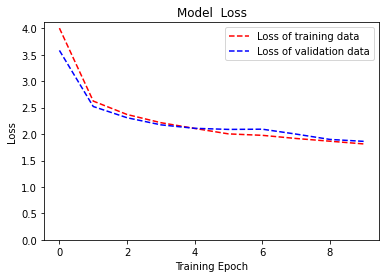

In [55]:
# for i in history.history:
#     print("history",i)
# plt.figure(figsize=(10, 8))
import csv
print(len(history.history['loss']))
result = csv.reader(open("/media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/trainvsval.csv","r"))
train_data =[]
val_data=[]
for line in result:
#     data = line.split(",")
    train_data.append(float(line[0]))
    val_data.append(float(line[1]))
    

# for i in range(0,len(history.history['loss'])):
# #     print(history.history['loss'][i],history.history['val_loss'][i])
#     result.writelines(str(history.history['loss'][i])+","+str(history.history['val_loss'][i])+"\n")
plt.plot(train_data, 'r--', label='Loss of training data')
plt.plot(val_data, 'b--', label='Loss of validation data')
plt.title('Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()